In [3]:
## Import necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

##### tqdm: A library to display progress bars during iterations or loops. It's particularly useful when you have long-running tasks, so you can track the progress visually

In [2]:
from tqdm import tqdm

In [3]:
# test = pd.read_csv('data/test.csv')
# test.shape

In [4]:
# test.head()

### Import Impression,log and Item data

In [5]:
impr = pd.read_csv('impression.csv')
logs = pd.read_csv('view_log.csv')
items = pd.read_csv('item_data.csv')

In [6]:
# dropping duplicate records
   
impr.drop_duplicates(inplace=True)
logs.drop_duplicates(inplace=True)
items.drop_duplicates(inplace=True)

print(impr.shape, logs.shape, items.shape)

(237609, 7) (3017496, 5) (132761, 6)


In [7]:
display(impr.head())
display(logs.head())
display(items.head())

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


### Exploratory Data Analysis

In [8]:
## Check for null values

display(impr.isna().sum(axis=0))
display(logs.isna().sum(axis=0))
display(items.isna().sum(axis=0))

impression_id      0
impression_time    0
user_id            0
app_code           0
os_version         0
is_4G              0
is_click           0
dtype: int64

server_time    0
device_type    0
session_id     0
user_id        0
item_id        0
dtype: int64

item_id         0
item_price      0
category_1      0
category_2      0
category_3      0
product_type    0
dtype: int64

In [9]:
# 4.57% positive samples, imbalanced dataset
np.round(impr['is_click'].value_counts(normalize=True), 4 )* 100 

0    95.43
1     4.57
Name: is_click, dtype: float64

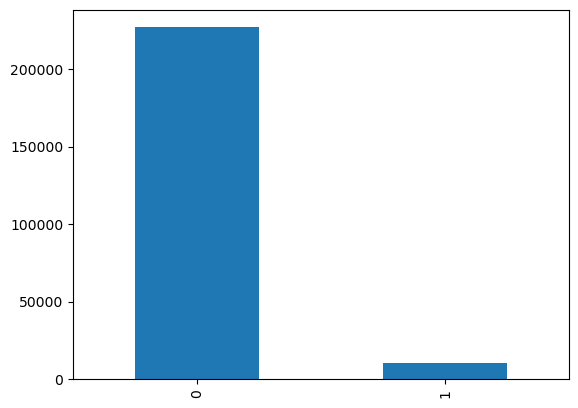

In [10]:
impr['is_click'].value_counts(normalize=False).plot(kind='bar');

In [11]:
# unique user_id count and intersection of user_id in impr and logs
print('unique user count : ', impr.user_id.nunique(), '\nusers common in impr and logs : ', len(set(impr.user_id.values) & set(logs.user_id.values)))

# unique item_id count and intersection of item_id in items and logs
print('unique items count : ', items.item_id.nunique(), '\nitems common in logs and items : ', len(set(items.item_id.values) & set(logs.item_id.values)))

# There are few missing items

unique user count :  74723 
users common in impr and logs :  74723
unique items count :  132761 
items common in logs and items :  126607


In [12]:
# # unique dates in impr dataset
# print('impr dates : ')
# print(np.sort(impr['impression_time'].map(lambda x : x.split(' ')[0]).unique()))

# # unique dates in logs dataset
# print('\nview log dates : ')
# print(np.sort(logs['server_time'].map(lambda x : x.split(' ')[0]).unique()))

In [13]:
# # unique dates test dataset
# print(np.sort(test['impression_time'].map(lambda x : x.split(' ')[0]).unique()))

In [14]:
# impr['user_id'].nunique(), test['user_id'].nunique() , len(set(test['user_id'].values) & set(impr['user_id'].values))

In [15]:
# merge items info with logs
logs = pd.merge(logs, items, on='item_id', how='left')

#### This function can be useful for getting a quick overview of the characteristics of the columns in a DataFrame, such as the number of missing values, data types, and unique values in each column.

In [19]:
def get_df_summary(df):
    info_df = pd.DataFrame({'name':[], 'count':[], 'missing_count': [], 'missing_perc': [], 'cardinality' : [], 'dtype':[]})
    for column in df.columns: 
        missing_count = df[column].isnull().sum()
        missing_perc = (np.round(missing_count/df[column].size, 4)) * 100
        count = df[column].size - missing_count
        cardinality = df[column].nunique()
        dtype = df[column].dtype
        temp_df = pd.DataFrame({'name':[column], 'count':[count], 'missing_count': [missing_count], 'missing_perc': [missing_perc], 'cardinality' : [cardinality], 'dtype':[dtype]})
        info_df = info_df.append(temp_df, ignore_index=True)
    return info_df

In [17]:
display(get_df_summary(logs))
display(get_df_summary(impr))

,name,count,missing_count,missing_perc,cardinality,dtype
0,server_time,3017496.0,0.0,0.00,82840.0,object
1,device_type,3017496.0,0.0,0.00,3.0,object
2,session_id,3017496.0,0.0,0.00,1014970.0,int64
3,user_id,3017496.0,0.0,0.00,89157.0,int64
4,item_id,3017496.0,0.0,0.00,126708.0,int64
5,item_price,3015746.0,1750.0,0.06,13207.0,float64
6,category_1,3015746.0,1750.0,0.06,17.0,float64
7,category_2,3015746.0,1750.0,0.06,79.0,float64
8,category_3,3015746.0,1750.0,0.06,335.0,float64
9,product_type,3015746.0,1750.0,0.06,7846.0,float64


,name,count,missing_count,missing_perc,cardinality,dtype
0,impression_id,237609.0,0.0,0.0,237609.0,object
1,impression_time,237609.0,0.0,0.0,36461.0,object
2,user_id,237609.0,0.0,0.0,74723.0,int64
3,app_code,237609.0,0.0,0.0,490.0,int64
4,os_version,237609.0,0.0,0.0,3.0,object
5,is_4G,237609.0,0.0,0.0,2.0,int64
6,is_click,237609.0,0.0,0.0,2.0,int64


In [18]:
# convert timestamps into datetime format
impr['impression_time'] = pd.to_datetime(impr['impression_time'], format='%Y-%m-%d %H:%M:%S')
logs['server_time'] = pd.to_datetime(logs['server_time'], format='%Y-%m-%d %H:%M:%S')

In [19]:
logs.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type
0,2018-10-15 08:58:00,android,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0
1,2018-10-15 08:58:00,android,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0
2,2018-10-15 08:58:00,android,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0
3,2018-10-15 08:58:00,android,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0
4,2018-10-15 08:58:00,android,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0


In [20]:
impr.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [21]:
# sort impr df by user_id and impression_time
impr.sort_values(by=['user_id', 'impression_time'], inplace=True, ignore_index=True)

In [22]:
# generate "tsli" : time since last impression in seconds

previous_userid = None
previous_ts = None
tsli_list = []

for idx, row in impr.iterrows(): 
    
    # if idx == 20: break

    user_id = row['user_id']
    impr_ts = row['impression_time']


    if user_id != previous_userid: 
        tsli = np.NaN # assign null value if there is no previous impression
        previous_userid = user_id
        previous_ts = impr_ts
    else : 
        tsli = (impr_ts - previous_ts).seconds
        previous_ts = impr_ts        

    tsli_list.append(tsli)
    # print(idx, user_id, impr_ts, tsli)

impr['tsli'] = tsli_list

In [23]:
# impr.app_code.nunique(), impr.app_code.value_counts()

In [1]:
##generating below features

In [24]:
"""
generating below features
    1. "tsli" : time since last impression in seconds
    2. "tslc" : time since last click in seconds
    3. "cnt_hi" : total count of historical impressions
    4. "cnt_hc" : total count of historical clicks
    5. "last_imp_appcode" : app_code for which last impression happened 
    6. "last_clk_appcode" : app_code for which last click happened 
    7. "unique_appcode_cnt" : unique app_code impression count
"""

row_format = '{:<25}'* 11
print(row_format.format(*['idx', 'user_id', 'is_click', 'imp_ts', 'tsli', 'tslc', 'cnt_hi', 'cnt_hc', 'app_code', 'last_imp_appcode', 'last_clk_appcode']))

previous_userid = None
previous_imp_ts = None
previous_clk_ts = None

tsli_list = []
tslc_list = []
cnt_hi_list = []
cnt_hc_list = []
last_imp_appcode_list = []
last_clk_appcode_list = []
unique_appcode_cnt_list = []

for idx, row in impr.iterrows(): 
    
    # if idx == 60: break

    user_id = row['user_id']
    imp_ts = row['impression_time']
    

    if user_id != previous_userid: 
        
        tsli = np.NaN # assign null value if there is no previous impression
        tslc = np.NaN # assign null value if there is no previous click

        cnt_hi = 0
        cnt_hc = 0

        last_imp_appcode = np.NaN
        last_clk_appcode = np.NaN

        unique_appcode_cnt = 1

        ####################################

        previous_userid = user_id
        
        previous_imp_ts = imp_ts
        previous_clk_ts = imp_ts if row['is_click'] else None

        temp_imp_cnt = 1
        temp_clk_cnt = 1 if row['is_click'] else 0

        previous_imp_appcode = row['app_code']
        previous_clk_appcode = row['app_code'] if row['is_click'] else None

        temp_appcode_set = set([row['app_code']])


    else : 

        tsli = (imp_ts - previous_imp_ts).total_seconds()
        tslc = (imp_ts - previous_clk_ts).total_seconds() if previous_clk_ts else np.NaN

        cnt_hi = temp_imp_cnt
        cnt_hc = temp_clk_cnt

        last_imp_appcode = previous_imp_appcode
        last_clk_appcode = previous_clk_appcode if not pd.isna(previous_clk_appcode) else np.NaN # bug when app_code is 0

        ####################################
        
        previous_imp_ts = imp_ts        
        if row['is_click']: previous_clk_ts = imp_ts 

        temp_imp_cnt += 1
        if row['is_click']: temp_clk_cnt += 1

        previous_imp_appcode = row['app_code']        
        if row['is_click']: previous_clk_appcode = row['app_code']

        temp_appcode_set.add(row['app_code'])
        unique_appcode_cnt = len(temp_appcode_set)

    tsli_list.append(tsli)
    tslc_list.append(tslc)
    cnt_hi_list.append(cnt_hi)
    cnt_hc_list.append(cnt_hc)
    last_imp_appcode_list.append(last_imp_appcode)
    last_clk_appcode_list.append(last_clk_appcode)
    unique_appcode_cnt_list.append(unique_appcode_cnt)


    # print(row_format.format(*[idx, user_id, row['is_click'], str(imp_ts), tsli, tslc, cnt_hi, cnt_hc, row['app_code'], last_imp_appcode, last_clk_appcode]))

impr['tsli'] = tsli_list
impr['tslc'] = tslc_list
impr['cnt_hi'] = cnt_hi_list
impr['cnt_hc'] = cnt_hc_list
impr['last_imp_appcode'] = last_imp_appcode_list
impr['last_clk_appcode'] = last_clk_appcode_list
impr['unique_appcode_cnt'] = unique_appcode_cnt_list

idx                      user_id                  is_click                 imp_ts                   tsli                     tslc                     cnt_hi                   cnt_hc                   app_code                 last_imp_appcode         last_clk_appcode         


In [25]:
impr['imp_day'] = impr['impression_time'].dt.day
impr['imp_week'] = impr['impression_time'].dt.weekday
impr['imp_hour'] = impr['impression_time'].dt.hour

In [26]:
impr.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,tsli,tslc,cnt_hi,cnt_hc,last_imp_appcode,last_clk_appcode,unique_appcode_cnt,imp_day,imp_week,imp_hour
0,5f98c2c31a8006e510448c02ec74d50f,2018-11-26 23:30:00,0,207,old,0,0,NaN,NaN,0,0,NaN,NaN,1,26,0,23
1,2b12c0d47f5821a5adb3bfd973d0f708,2018-11-19 20:49:00,2,190,intermediate,0,0,NaN,NaN,0,0,NaN,NaN,1,19,0,20
2,f85e4bf0e34f3ee66add56229845e4db,2018-11-20 20:29:00,2,190,intermediate,0,0,85200.0,NaN,1,0,190.0,NaN,1,20,1,20
3,010ed37e44e2fdc175b4c5c6c930805a,2018-11-20 20:53:00,2,190,intermediate,0,0,1440.0,NaN,2,0,190.0,NaN,1,20,1,20
4,577c63f9937fa0e8d4650ddf1510a03f,2018-11-21 21:47:00,2,190,intermediate,0,0,89640.0,NaN,3,0,190.0,NaN,1,21,2,21


In [27]:
# impr.shape, impr['cnt_hi'].sum(), impr['cnt_hc'].sum(), impr['is_click'].sum(), impr['cnt_hc'].value_counts()

In [28]:
## Get the statistic summary for impr dataset

get_df_summary(impr)

,name,count,missing_count,missing_perc,cardinality,dtype
0,impression_id,237609.0,0.0,0.00,237609.0,object
1,impression_time,237609.0,0.0,0.00,36461.0,datetime64[ns]
2,user_id,237609.0,0.0,0.00,74723.0,int64
3,app_code,237609.0,0.0,0.00,490.0,int64
4,os_version,237609.0,0.0,0.00,3.0,object
5,is_4G,237609.0,0.0,0.00,2.0,int64
6,is_click,237609.0,0.0,0.00,2.0,int64
7,tsli,162886.0,74723.0,31.45,18624.0,float64
8,tslc,31075.0,206534.0,86.92,15248.0,float64
9,cnt_hi,237609.0,0.0,0.00,73.0,int64


In [29]:
# impr[impr['cnt_hc']==3]
# impr[impr['user_id']==135]

In [30]:
# to fix mismatch in tslc and last_clk_appcode
# impr[(~impr['tslc'].isna()) & (impr['last_clk_appcode'].isna())]
# impr[impr['user_id']==30522]

In [31]:
# temp = impr.groupby('user_id').agg({'is_click':sum}).reset_index()
# impr.is_click.sum(), temp.sort_values(by='is_click', ascending=False).head(1000)

In [32]:
##  Find Max,Min,Median,Mean and Std for tsli variable

impr.tsli.max(), impr.tsli.min(), impr.tsli.median(), impr.tsli.mean(), impr.tsli.std()

(2373120.0, 0.0, 56760.0, 180562.3381997225, 312736.67253258365)

In [33]:
impr

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,tsli,tslc,cnt_hi,cnt_hc,last_imp_appcode,last_clk_appcode,unique_appcode_cnt,imp_day,imp_week,imp_hour
0,5f98c2c31a8006e510448c02ec74d50f,2018-11-26 23:30:00,0,207,old,0,0,NaN,NaN,0,0,NaN,NaN,1,26,0,23
1,2b12c0d47f5821a5adb3bfd973d0f708,2018-11-19 20:49:00,2,190,intermediate,0,0,NaN,NaN,0,0,NaN,NaN,1,19,0,20
2,f85e4bf0e34f3ee66add56229845e4db,2018-11-20 20:29:00,2,190,intermediate,0,0,85200.0,NaN,1,0,190.0,NaN,1,20,1,20
3,010ed37e44e2fdc175b4c5c6c930805a,2018-11-20 20:53:00,2,190,intermediate,0,0,1440.0,NaN,2,0,190.0,NaN,1,20,1,20
4,577c63f9937fa0e8d4650ddf1510a03f,2018-11-21 21:47:00,2,190,intermediate,0,0,89640.0,NaN,3,0,190.0,NaN,1,21,2,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237604,cf34ea8f2355f9f3f33c5a6ce1453dcc,2018-12-02 19:00:00,92583,407,latest,1,0,240.0,NaN,1,0,407.0,NaN,1,2,6,19
237605,45f849f13e9103e5215941226d5fc2d7,2018-12-10 21:41:00,92585,386,intermediate,0,0,NaN,NaN,0,0,NaN,NaN,1,10,0,21
237606,c0932ce334136e34b5a9a1c57bb611e3,2018-12-05 23:17:00,92586,386,latest,1,0,NaN,NaN,0,0,NaN,NaN,1,5,2,23
237607,6035edcd398af41b455f203b53b48c61,2018-12-06 00:10:00,92586,386,latest,1,0,3180.0,NaN,1,0,386.0,NaN,1,6,3,0


In [34]:
impr.to_csv("Impr.csv",index=False)

### Deriving log features

In [35]:
logs.sort_values(by=['user_id', 'server_time'], ignore_index=True, inplace=True)
logs.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type
0,2018-10-18 14:27:00,android,268465,0,44459,3776.0,14.0,29.0,199.0,7363.0
1,2018-10-18 14:43:00,android,268465,0,44459,3776.0,14.0,29.0,199.0,7363.0
2,2018-10-18 14:46:00,android,268465,0,44459,3776.0,14.0,29.0,199.0,7363.0
3,2018-10-18 14:47:00,android,268465,0,44459,3776.0,14.0,29.0,199.0,7363.0
4,2018-10-22 09:48:00,android,295495,0,40228,332.0,7.0,24.0,126.0,8351.0


In [36]:
## Summary of logs data set

get_df_summary(logs)

,name,count,missing_count,missing_perc,cardinality,dtype
0,server_time,3017496.0,0.0,0.00,82840.0,datetime64[ns]
1,device_type,3017496.0,0.0,0.00,3.0,object
2,session_id,3017496.0,0.0,0.00,1014970.0,int64
3,user_id,3017496.0,0.0,0.00,89157.0,int64
4,item_id,3017496.0,0.0,0.00,126708.0,int64
5,item_price,3015746.0,1750.0,0.06,13207.0,float64
6,category_1,3015746.0,1750.0,0.06,17.0,float64
7,category_2,3015746.0,1750.0,0.06,79.0,float64
8,category_3,3015746.0,1750.0,0.06,335.0,float64
9,product_type,3015746.0,1750.0,0.06,7846.0,float64


In [37]:
get_df_summary(impr)

,name,count,missing_count,missing_perc,cardinality,dtype
0,impression_id,237609.0,0.0,0.00,237609.0,object
1,impression_time,237609.0,0.0,0.00,36461.0,datetime64[ns]
2,user_id,237609.0,0.0,0.00,74723.0,int64
3,app_code,237609.0,0.0,0.00,490.0,int64
4,os_version,237609.0,0.0,0.00,3.0,object
5,is_4G,237609.0,0.0,0.00,2.0,int64
6,is_click,237609.0,0.0,0.00,2.0,int64
7,tsli,162886.0,74723.0,31.45,18624.0,float64
8,tslc,31075.0,206534.0,86.92,15248.0,float64
9,cnt_hi,237609.0,0.0,0.00,73.0,int64


In [38]:
# fill missing values
logs['item_price'].fillna(logs['item_price'].mean(), inplace=True)
logs['category_1'] = logs['category_1'].fillna('NA').astype(str)
logs['category_2'] = logs['category_2'].fillna('NA').astype(str)
logs['category_3'] = logs['category_3'].fillna('NA').astype(str)
logs['product_type'] = logs['product_type'].fillna('NA').astype(str)

In [39]:
get_df_summary(logs)

,name,count,missing_count,missing_perc,cardinality,dtype
0,server_time,3017496.0,0.0,0.0,82840.0,datetime64[ns]
1,device_type,3017496.0,0.0,0.0,3.0,object
2,session_id,3017496.0,0.0,0.0,1014970.0,int64
3,user_id,3017496.0,0.0,0.0,89157.0,int64
4,item_id,3017496.0,0.0,0.0,126708.0,int64
5,item_price,3017496.0,0.0,0.0,13208.0,float64
6,category_1,3017496.0,0.0,0.0,18.0,object
7,category_2,3017496.0,0.0,0.0,80.0,object
8,category_3,3017496.0,0.0,0.0,336.0,object
9,product_type,3017496.0,0.0,0.0,7847.0,object


In [40]:
impr.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,tsli,tslc,cnt_hi,cnt_hc,last_imp_appcode,last_clk_appcode,unique_appcode_cnt,imp_day,imp_week,imp_hour
0,5f98c2c31a8006e510448c02ec74d50f,2018-11-26 23:30:00,0,207,old,0,0,NaN,NaN,0,0,NaN,NaN,1,26,0,23
1,2b12c0d47f5821a5adb3bfd973d0f708,2018-11-19 20:49:00,2,190,intermediate,0,0,NaN,NaN,0,0,NaN,NaN,1,19,0,20
2,f85e4bf0e34f3ee66add56229845e4db,2018-11-20 20:29:00,2,190,intermediate,0,0,85200.0,NaN,1,0,190.0,NaN,1,20,1,20
3,010ed37e44e2fdc175b4c5c6c930805a,2018-11-20 20:53:00,2,190,intermediate,0,0,1440.0,NaN,2,0,190.0,NaN,1,20,1,20
4,577c63f9937fa0e8d4650ddf1510a03f,2018-11-21 21:47:00,2,190,intermediate,0,0,89640.0,NaN,3,0,190.0,NaN,1,21,2,21


In [41]:
# logs.head(50)

In [42]:

# row_format = '{:<25}'* 11
# print(row_format.format(*['idx', 'user_id', 'is_click', 'imp_ts', 'tsli', 'tslc', 'cnt_hi', 'cnt_hc', 'app_code', 'last_imp_appcode', 'last_clk_appcode']))

# previous_userid = None
# previous_server_ts = None

# # tsli_list = []
# # tslc_list = []
# # cnt_hi_list = []
# # cnt_hc_list = []
# # last_imp_appcode_list = []
# # last_clk_appcode_list = []
# # unique_appcode_cnt_list = []

# for idx, row in logs.iterrows(): 
    
#     if idx == 60: break

#     user_id = row['user_id']
#     imp_ts = row['server_time']
    

#     if user_id != previous_userid: 
        
#         tsli = np.NaN # assign null value if there is no previous impression
#         tslc = np.NaN # assign null value if there is no previous impression

#         cnt_hi = 0
#         cnt_hc = 0

#         last_imp_appcode = np.NaN
#         last_clk_appcode = np.NaN

#         unique_appcode_cnt = 1

#         ####################################

#         previous_userid = user_id
        
#         previous_imp_ts = imp_ts
#         previous_clk_ts = imp_ts if row['is_click'] else None

#         temp_imp_cnt = 1
#         temp_clk_cnt = 1 if row['is_click'] else 0

#         previous_imp_appcode = row['app_code']
#         previous_clk_appcode = row['app_code'] if row['is_click'] else None

#         temp_appcode_set = set([row['app_code']])


#     else : 

#         tsli = (imp_ts - previous_imp_ts).total_seconds()
#         tslc = (imp_ts - previous_clk_ts).total_seconds() if previous_clk_ts else np.NaN

#         cnt_hi = temp_imp_cnt
#         cnt_hc = temp_clk_cnt

#         last_imp_appcode = previous_imp_appcode
#         last_clk_appcode = previous_clk_appcode if not pd.isna(previous_clk_appcode) else np.NaN # bug when app_code is 0

#         ####################################
        
#         previous_imp_ts = imp_ts        
#         if row['is_click']: previous_clk_ts = imp_ts 

#         temp_imp_cnt += 1
#         if row['is_click']: temp_clk_cnt += 1

#         previous_imp_appcode = row['app_code']        
#         if row['is_click']: previous_clk_appcode = row['app_code']

#         temp_appcode_set.add(row['app_code'])
#         unique_appcode_cnt = len(temp_appcode_set)

#     tsli_list.append(tsli)
#     tslc_list.append(tslc)
#     cnt_hi_list.append(cnt_hi)
#     cnt_hc_list.append(cnt_hc)
#     last_imp_appcode_list.append(last_imp_appcode)
#     last_clk_appcode_list.append(last_clk_appcode)
#     unique_appcode_cnt_list.append(unique_appcode_cnt)


#     # print(row_format.format(*[idx, user_id, row['is_click'], str(imp_ts), tsli, tslc, cnt_hi, cnt_hc, row['app_code'], last_imp_appcode, last_clk_appcode]))

# impr['tsli'] = tsli_list
# impr['tslc'] = tslc_list
# impr['cnt_hi'] = cnt_hi_list
# impr['cnt_hc'] = cnt_hc_list
# impr['last_imp_appcode'] = last_imp_appcode_list
# impr['last_clk_appcode'] = last_clk_appcode_list
# impr['unique_appcode_cnt'] = unique_appcode_cnt_list

In [43]:
# impr['impression_time'].dt.day.value_counts()
# impr['impression_time'].dt.weekday.value_counts()
# impr['impression_time'].dt.hour.value_counts()

# logs['server_time'].dt.day.value_counts()
# logs['server_time'].dt.weekday.value_counts()
# logs['server_time'].dt.hour.value_counts()

In [44]:
# # logs_filt.pivot_table(index='user_id', columns=['server_day'], aggfunc='sum') # aggfunc={'server_day':'sum'}
# # pd.pivot_table(logs_filt, index='user_id', values=['server_hour'], aggfunc=np.sum).reset_index()

# final_dict = {}

# cols = ['day', 'week', 'hour', 'category_1', 'category_2']

# for col in cols: 

#     temp = logs_filt.groupby(col).agg({col:np.size})
#     temp.columns = ['count']
#     temp.reset_index(inplace=True)
#     temp[col] = temp[col].map(lambda x: f'act_cnt_{col}_{x}')
#     final_dict.update(dict(temp.values.tolist()))

# final_dict

In [45]:
# # combination of these 3 cols is unique : 'user_id', 'impression_time', 'impression_id'

# display(impr.shape)
# impr.drop_duplicates(subset=['user_id', 'impression_time', 'impression_id']).shape

In [46]:
logs['day'] = logs['server_time'].dt.day
logs['week'] = logs['server_time'].dt.weekday
logs['hour'] = logs['server_time'].dt.hour

In [47]:
logs.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type,day,week,hour
0,2018-10-18 14:27:00,android,268465,0,44459,3776.0,14.0,29.0,199.0,7363.0,18,3,14
1,2018-10-18 14:43:00,android,268465,0,44459,3776.0,14.0,29.0,199.0,7363.0,18,3,14
2,2018-10-18 14:46:00,android,268465,0,44459,3776.0,14.0,29.0,199.0,7363.0,18,3,14
3,2018-10-18 14:47:00,android,268465,0,44459,3776.0,14.0,29.0,199.0,7363.0,18,3,14
4,2018-10-22 09:48:00,android,295495,0,40228,332.0,7.0,24.0,126.0,8351.0,22,0,9


In [ ]:
## Deriving Important features from Log dataset

In [48]:
"""
log features : 

    'tsla' : time since last activity
    'cnt_ha' : count of historical activity
    'unq_sess_cnt' unique sessions count
    'last_price' : price of last viewed item
    'sum_price' : sum of price of all viewed items
    'mean_price' : mean of price of all viewed items
    'std_price' : std deviation of price of all viewed items
    'act_cnt_{week}'
    'act_cnt_{day}'
    'act_cnt_{hour}'
    'act_cnt_{cat1}'
    'act_cnt_{cat2}'
    X 'tot_act_cnt_{cat3}'
    'ls_cat1' : last seen category_1
    'ls_cat2' : last seen category_2
    'ls_cat3' : last seen category_3
    'ls_prd' : last seen product_type
    'unq_cat1_cnt' : unique category_3 count    
    'unq_cat2_cnt' : unique category_3 count
    'unq_cat3_cnt' : unique category_3 count
    'unq_prd_cnt' : unique product_type count

    sum of item_price / unique product_type
    unique price mean
    prd qty / cat_1
    prd qty / cat_2
    prd qty / cat_3
"""

no_act_cnt = 0 
def get_act_feats(user_id, imp_time, impression_id, logs): 
    
    logs_filt = logs[(logs['user_id']==user_id) & (logs['server_time']<imp_time)]
    no_logs = False # flag is set to True when there is no historical activity by user
    if logs_filt.shape[0] == 0: 
        no_logs = True
        # print('no historical logs', user_id, imp_time)
    # display(logs_filt)

    # tsla = (imp_time - logs_filt['server_time'].max()).total_seconds()
    tsla = np.NaN if no_logs else (imp_time - logs_filt['server_time'].values[-1]).total_seconds()
    cnt_ha = len(logs_filt)
    unq_sess_cnt = logs_filt['session_id'].nunique()
    last_price = np.NaN if no_logs else logs_filt['item_price'].values[-1]
    sum_price = logs_filt['item_price'].sum()
    mean_price = logs_filt['item_price'].mean()
    std_price = logs_filt['item_price'].std()

    ls_cat1 = np.NaN if no_logs else logs_filt['category_1'].values[-1]
    ls_cat2 = np.NaN if no_logs else logs_filt['category_2'].values[-1]
    ls_cat3 = np.NaN if no_logs else logs_filt['category_3'].values[-1]
    ls_prd = np.NaN if no_logs else logs_filt['product_type'].values[-1]

    unq_cat1_cnt = logs_filt['category_1'].nunique()
    unq_cat2_cnt = logs_filt['category_2'].nunique()
    unq_cat3_cnt = logs_filt['category_3'].nunique()
    unq_prd_cnt = logs_filt['product_type'].nunique()


    temp_dict = {"tsla":tsla, "cnt_ha":cnt_ha, "unq_sess_cnt":unq_sess_cnt, "last_price":last_price, \
        "sum_price":sum_price, "mean_price":mean_price, "std_price":std_price, "ls_cat1":ls_cat1, "ls_cat2":ls_cat2, \
            "ls_cat3":ls_cat3, "ls_prd":ls_prd, "unq_cat1_cnt":unq_cat1_cnt, "unq_cat2_cnt":unq_cat2_cnt, \
                "unq_cat3_cnt":unq_cat3_cnt, "unq_prd_cnt":unq_prd_cnt}

    temp_dict.update({'user_id':user_id, 'impression_id':impression_id, 'impression_time':imp_time})    
                
    cols = ['day', 'week', 'hour', 'category_1', 'category_2']

    for col in cols: 

        temp = logs_filt.groupby(col).agg({col:np.size})
        temp.columns = ['count']
        temp.reset_index(inplace=True)
        temp[col] = temp[col].map(lambda x: f'act_cnt_{col}_{x}')
        temp_dict.update(dict(temp.values.tolist()))
    
    return temp_dict

# check for sample values
# user_id = 0
# imp_time = pd.to_datetime('2018-11-26 23:30:00')
# get_act_feats(user_id, imp_time, '5f98c2c31a8006e510448c02ec74d50f', logs)

In [46]:
# generate temp dataframe containing all possible cols which can be derived from logs
cols = ['user_id', 'impression_id', 'impression_time'] + ['tsla', 'cnt_ha', 'unq_sess_cnt', 'last_price', 'sum_price', 'mean_price', 'std_price', 'ls_cat1', 'ls_cat2', 'ls_cat3', 'ls_prd', 'unq_cat1_cnt', 'unq_cat2_cnt', 'unq_cat3_cnt', 'unq_prd_cnt']

day_cols = [f'act_cnt_day_{i}' for i in sorted(logs.day.unique())]
week_cols = [f'act_cnt_week_{i}' for i in sorted(logs.week.unique())]
hour_cols = [f'act_cnt_hour_{i}' for i in sorted(logs.hour.unique())]

cat1_cols = [f'act_cnt_category_1_{i}' for i in sorted(logs.category_1.unique())]
cat2_cols = [f'act_cnt_category_2_{i}' for i in sorted(logs.category_2.unique())]

temp_df = pd.DataFrame(columns=cols + day_cols + week_cols + hour_cols + cat1_cols + cat2_cols)
display(temp_df.shape)
temp_df.head()

(0, 178)

,user_id,impression_id,impression_time,tsla,cnt_ha,unq_sess_cnt,last_price,sum_price,mean_price,std_price,...,act_cnt_category_2_73.0,act_cnt_category_2_74.0,act_cnt_category_2_75.0,act_cnt_category_2_76.0,act_cnt_category_2_77.0,act_cnt_category_2_78.0,act_cnt_category_2_79.0,act_cnt_category_2_8.0,act_cnt_category_2_9.0,act_cnt_category_2_NA


In [47]:
## for loop is slow. So use joblib

# for n, row in impr.head(1000).iterrows(): 
    
#     # if n==5: break
#     # print(n, row)

#     temp_df = temp_df.append(get_act_feats(row['user_id'], row['impression_time'], row['impression_id'], logs), ignore_index=True)

In [49]:
from joblib import Parallel, delayed

multi_outputs = Parallel(n_jobs=6, prefer="threads", verbose=0)(delayed(get_act_feats)(row['user_id'], row['impression_time'], row['impression_id'], logs) for _, row in tqdm(impr.iterrows()))
temp_df = temp_df.append([i for i in multi_outputs], ignore_index=True)

3114it [01:20, 51.67it/s]

In [2]:
import pandas as pd

In [4]:
# save for later
# temp_df.to_csv('data/log_features.csv', index=False)

# load from saved file
temp_df = pd.read_csv('log_features.csv')
temp_df['impression_time'] = pd.to_datetime(temp_df['impression_time'], format='%Y-%m-%d %H:%M:%S')

In [5]:
display(temp_df.shape)
temp_df.head()

(237609, 178)

,user_id,impression_id,impression_time,tsla,cnt_ha,unq_sess_cnt,last_price,sum_price,mean_price,std_price,...,act_cnt_category_2_73.0,act_cnt_category_2_74.0,act_cnt_category_2_75.0,act_cnt_category_2_76.0,act_cnt_category_2_77.0,act_cnt_category_2_78.0,act_cnt_category_2_79.0,act_cnt_category_2_8.0,act_cnt_category_2_9.0,act_cnt_category_2_NA
0,0,5f98c2c31a8006e510448c02ec74d50f,2018-11-26 23:30:00,28560.0,28,7,19840.0,266800.0,9528.571429,20439.781947,...,NaN,1.0,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN
1,2,2b12c0d47f5821a5adb3bfd973d0f708,2018-11-19 20:49:00,21540.0,117,28,2419.0,1702407.0,14550.487179,31310.110698,...,NaN,2.0,NaN,2.0,1.0,2.0,NaN,7.0,2.0,NaN
2,2,f85e4bf0e34f3ee66add56229845e4db,2018-11-20 20:29:00,81780.0,121,30,602.0,1712591.0,14153.644628,30861.241363,...,NaN,2.0,NaN,2.0,1.0,2.0,NaN,7.0,2.0,NaN
3,2,010ed37e44e2fdc175b4c5c6c930805a,2018-11-20 20:53:00,83220.0,121,30,602.0,1712591.0,14153.644628,30861.241363,...,NaN,2.0,NaN,2.0,1.0,2.0,NaN,7.0,2.0,NaN
4,2,577c63f9937fa0e8d4650ddf1510a03f,2018-11-21 21:47:00,172860.0,121,30,602.0,1712591.0,14153.644628,30861.241363,...,NaN,2.0,NaN,2.0,1.0,2.0,NaN,7.0,2.0,NaN


In [6]:
# temp_df[(temp_df['std_price'].isna()) & (~temp_df['tsla'].isna())].head()
# temp_df[temp_df['impression_id']=='fb4cd2d75ba5915913d52e43c780c3d2']
# logs[logs['user_id']==5]

In [7]:
# a = get_df_summary(temp_df)

In [8]:
# # no logs user
# logs[logs['user_id']==98]

In [9]:
impr=pd.read_csv("Impr.csv")

In [10]:
impr_copy=impr.copy()

In [11]:
## Converting categorical variables to string datatype checking in impr_copy and temp_df dataset

cat_cols = ['app_code', 'os_version', 'is_4G', 'last_imp_appcode', 'last_clk_appcode', 'imp_day', 'imp_week', 'imp_hour', 'ls_cat1', 'ls_cat2', 'ls_cat3', 'ls_prd']

for col in cat_cols: 
    if col in impr_copy: 
        impr_copy[col] = impr_copy[col].astype(str)
    elif col in temp_df : 
        temp_df[col] = temp_df[col].astype(str)
    else : 
        pass

In [12]:
temp_df['impression_time'].dtype

dtype('<M8[ns]')

In [13]:
## Converting impression time to datetime datatype

impr_copy['impression_time'] = pd.to_datetime(impr_copy['impression_time'], format='%Y-%m-%d %H:%M:%S')

In [14]:
temp_df['impression_time'].dtype

dtype('<M8[ns]')

In [15]:
impr_copy['impression_time'].dtype

dtype('<M8[ns]')

In [16]:
## Merge both impr_copy and temp_df dataframe on common user_id,impression_id and impression_time variables

impr_view_df = pd.merge(impr_copy, temp_df, how='left', on=['user_id', 'impression_id', 'impression_time'])
impr_view_df

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,tsli,tslc,cnt_hi,...,act_cnt_category_2_73.0,act_cnt_category_2_74.0,act_cnt_category_2_75.0,act_cnt_category_2_76.0,act_cnt_category_2_77.0,act_cnt_category_2_78.0,act_cnt_category_2_79.0,act_cnt_category_2_8.0,act_cnt_category_2_9.0,act_cnt_category_2_NA
0,5f98c2c31a8006e510448c02ec74d50f,2018-11-26 23:30:00,0,207,old,0,0,NaN,NaN,0,...,NaN,1.0,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN
1,2b12c0d47f5821a5adb3bfd973d0f708,2018-11-19 20:49:00,2,190,intermediate,0,0,NaN,NaN,0,...,NaN,2.0,NaN,2.0,1.0,2.0,NaN,7.0,2.0,NaN
2,f85e4bf0e34f3ee66add56229845e4db,2018-11-20 20:29:00,2,190,intermediate,0,0,85200.0,NaN,1,...,NaN,2.0,NaN,2.0,1.0,2.0,NaN,7.0,2.0,NaN
3,010ed37e44e2fdc175b4c5c6c930805a,2018-11-20 20:53:00,2,190,intermediate,0,0,1440.0,NaN,2,...,NaN,2.0,NaN,2.0,1.0,2.0,NaN,7.0,2.0,NaN
4,577c63f9937fa0e8d4650ddf1510a03f,2018-11-21 21:47:00,2,190,intermediate,0,0,89640.0,NaN,3,...,NaN,2.0,NaN,2.0,1.0,2.0,NaN,7.0,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237604,cf34ea8f2355f9f3f33c5a6ce1453dcc,2018-12-02 19:00:00,92583,407,latest,1,0,240.0,NaN,1,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237605,45f849f13e9103e5215941226d5fc2d7,2018-12-10 21:41:00,92585,386,intermediate,0,0,NaN,NaN,0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
237606,c0932ce334136e34b5a9a1c57bb611e3,2018-12-05 23:17:00,92586,386,latest,1,0,NaN,NaN,0,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,2.0,NaN
237607,6035edcd398af41b455f203b53b48c61,2018-12-06 00:10:00,92586,386,latest,1,0,3180.0,NaN,1,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,2.0,NaN


In [20]:
impr_view_df_summary = get_df_summary(impr_view_df)
impr_view_df_summary.head()

,name,count,missing_count,missing_perc,cardinality,dtype
0,impression_id,237609.0,0.0,0.0,237609.0,object
1,impression_time,237609.0,0.0,0.0,36461.0,datetime64[ns]
2,user_id,237609.0,0.0,0.0,74723.0,int64
3,app_code,237609.0,0.0,0.0,490.0,object
4,os_version,237609.0,0.0,0.0,3.0,object


In [21]:
## If the missing percentage is >99% keeping those variables in cols_to_drop list

cols_to_drop = impr_view_df_summary[impr_view_df_summary['missing_perc']>99]['name'].tolist()
cols_to_drop

['act_cnt_category_1_2.0',
 'act_cnt_category_1_5.0',
 'act_cnt_category_2_11.0',
 'act_cnt_category_2_13.0',
 'act_cnt_category_2_16.0',
 'act_cnt_category_2_2.0',
 'act_cnt_category_2_22.0',
 'act_cnt_category_2_50.0',
 'act_cnt_category_2_53.0',
 'act_cnt_category_2_60.0',
 'act_cnt_category_2_65.0',
 'act_cnt_category_2_75.0']

In [22]:
# get_df_summary(impr_view_df).head(200).tail(50)

# temp = get_df_summary(impr_view_df)
# temp[temp['missing_count']>0]

In [23]:
count_cols = [i for i in impr_view_df if 'cnt' in i]
missing_cont_cols = ['tsli', 'tslc', 'tsla', 'last_price', 'mean_price', 'std_price']
missing_cat_cols = ['last_imp_appcode', 'last_clk_appcode', 'ls_cat1', 'ls_cat2', 'ls_cat3', 'ls_prd']

# imputing missing count_cols with 0
impr_view_df[count_cols] = impr_view_df[count_cols].fillna(0)

# imputing missing cont_cols with mean
for col in missing_cont_cols: 
    impr_view_df[col] = impr_view_df[col].fillna(impr_view_df[col].mean())

# imputing missing cat_cols with 'NA'
for col in missing_cat_cols: 
    impr_view_df[col] = impr_view_df[col].fillna('NA')

In [24]:
# count_cols = [i for i in impr_view_df if 'cnt' in i] # 169
cols_to_drop = ['impression_id', 'impression_time', 'user_id', ]
cont_cols = ['tsli', 'tslc', 'tsla', 'last_price', 'sum_price', 'mean_price', 'std_price']
cat_cols = ['app_code', 'os_version', 'is_4G', 'last_imp_appcode', 'last_clk_appcode', 'imp_day', 'imp_week', 'imp_hour', 'ls_cat1', 'ls_cat2', 'ls_cat3', 'ls_prd']
target = 'is_click'

ohe_cols = ['os_version', 'imp_day', 'imp_week', 'imp_hour', 'ls_cat1', 'ls_cat2']
te_cols = ['app_code', 'last_imp_appcode', 'last_clk_appcode', 'ls_cat3', 'ls_prd']
bin_cols = ['is_4G']

In [25]:
# checking unique values in cat_cols to decide type of encoding
temp = get_df_summary(impr_view_df)
temp[temp['name'].isin(cat_cols)]

,name,count,missing_count,missing_perc,cardinality,dtype
3,app_code,237609.0,0.0,0.0,490.0,object
4,os_version,237609.0,0.0,0.0,3.0,object
5,is_4G,237609.0,0.0,0.0,2.0,object
11,last_imp_appcode,237609.0,0.0,0.0,396.0,object
12,last_clk_appcode,237609.0,0.0,0.0,222.0,object
14,imp_day,237609.0,0.0,0.0,29.0,object
15,imp_week,237609.0,0.0,0.0,7.0,object
16,imp_hour,237609.0,0.0,0.0,24.0,object
24,ls_cat1,237609.0,0.0,0.0,16.0,object
25,ls_cat2,237609.0,0.0,0.0,76.0,object


In [26]:
# impr_view_df.shape, len(set(cols_to_drop+cont_cols+cat_cols+target+count_cols))

In [27]:
len(cat_cols), len((ohe_cols+te_cols+bin_cols))

(12, 12)

tsli


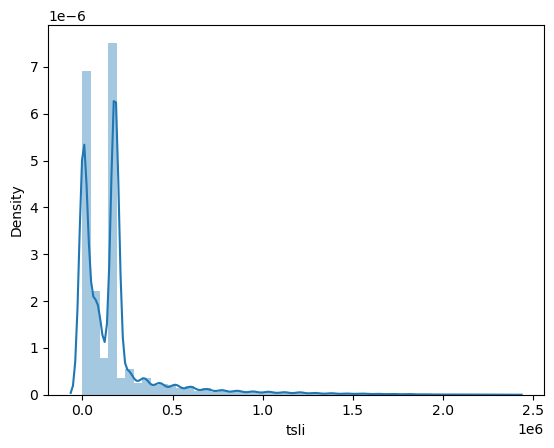

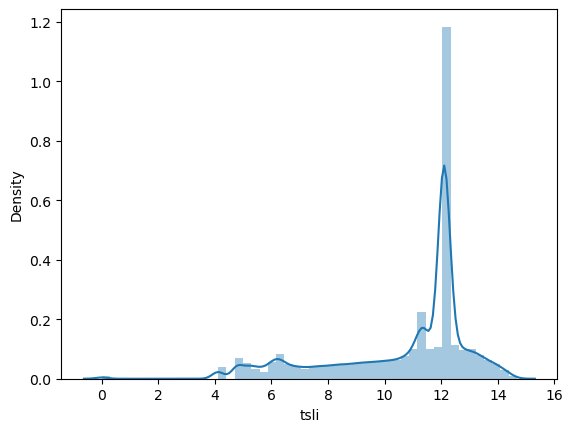

tslc


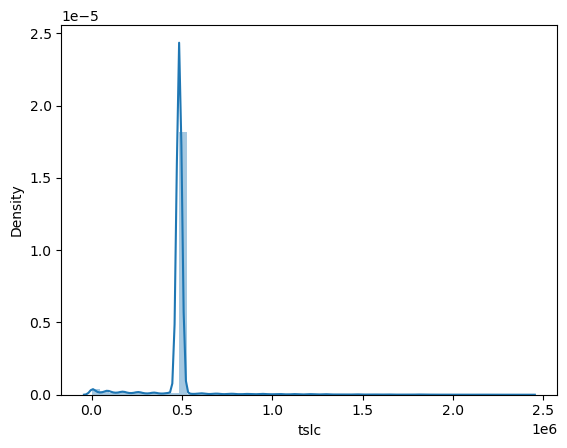

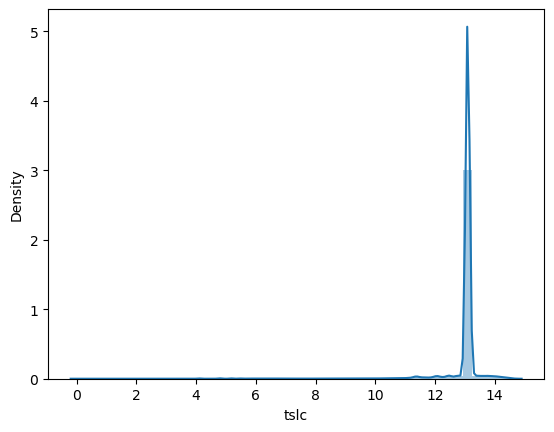

tsla


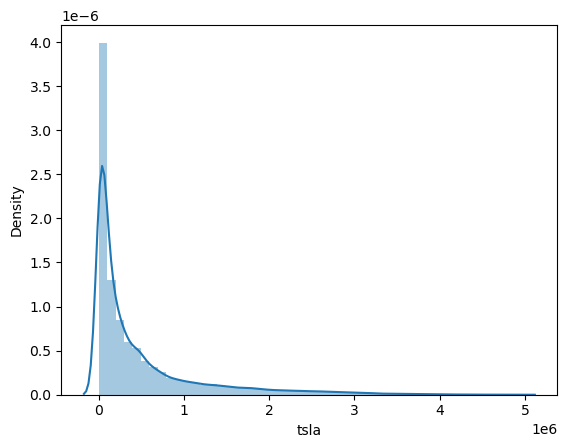

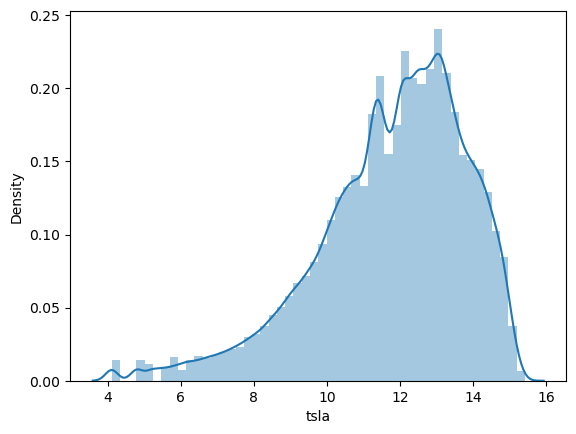

last_price


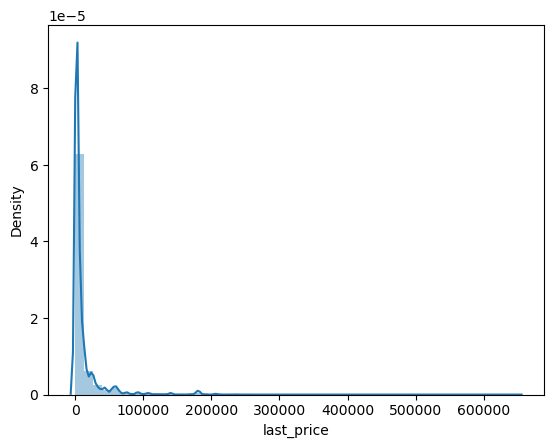

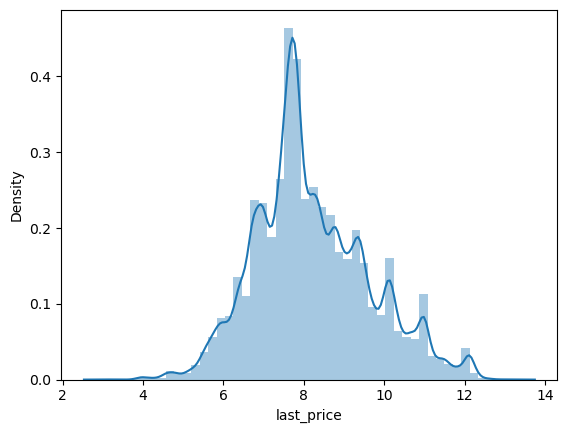

sum_price


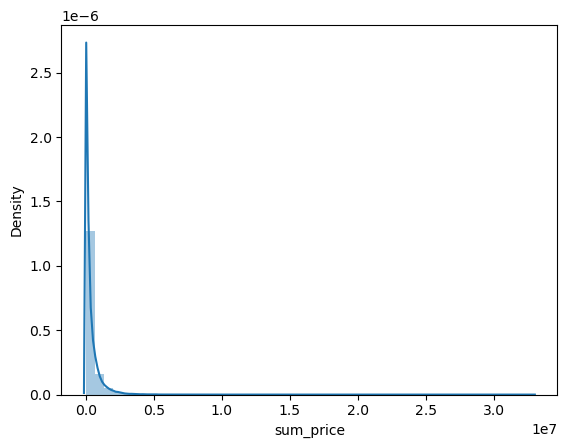

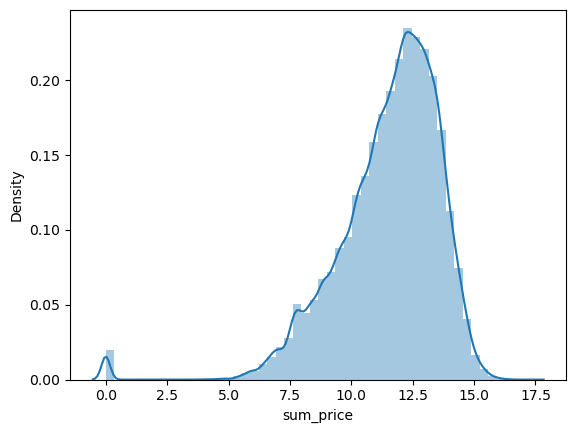

mean_price


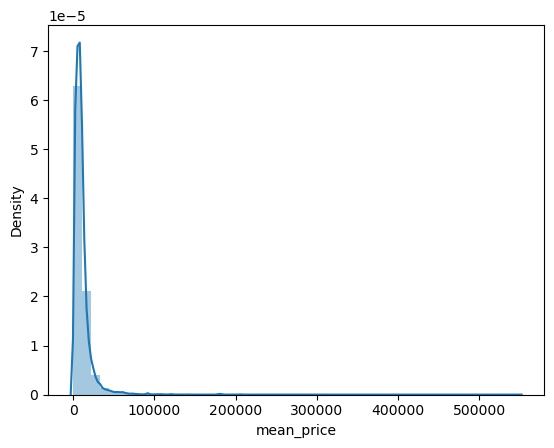

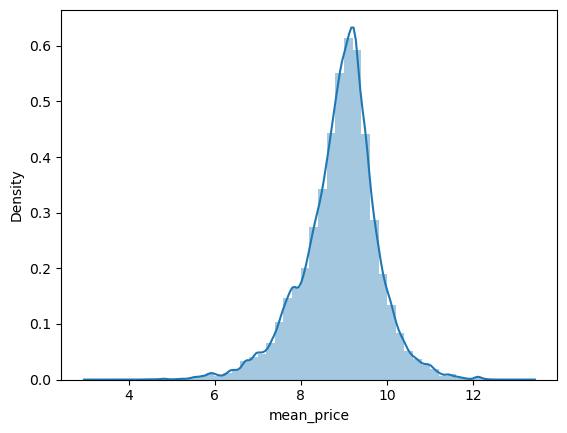

std_price


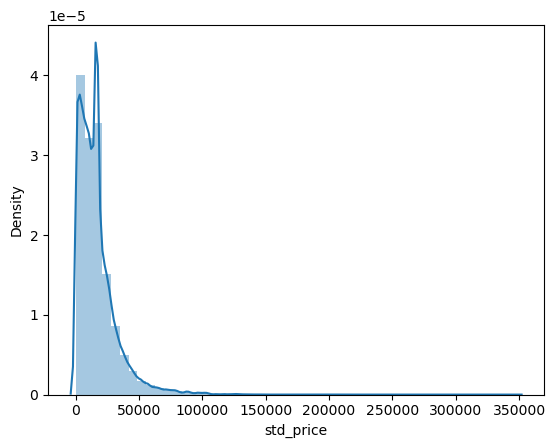

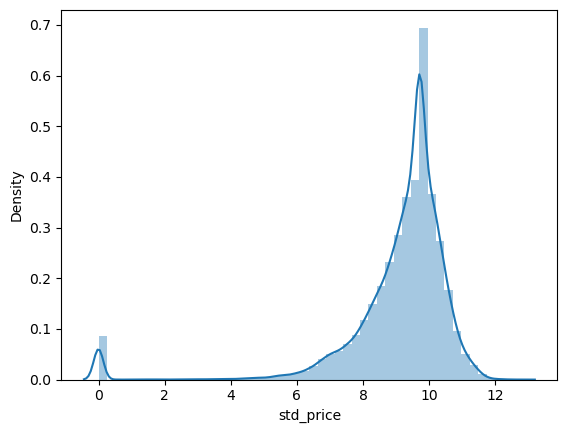

In [28]:
# taking log transform to remove skewness in continuous cols

for col in cont_cols: 
    print(col)
    sns.distplot(impr_view_df[col]);
    plt.show()    
    impr_view_df[col] = np.log1p(impr_view_df[col])
    sns.distplot(impr_view_df[col]);
    plt.show()


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(impr_view_df[count_cols+cols_to_drop+cont_cols+ohe_cols+te_cols+bin_cols],
                             impr_view_df[target], test_size=0.25, random_state=3, stratify=impr_view_df[target])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
display(y_train.value_counts(), y_test.value_counts())
display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

(178206, 191)

(59403, 191)

(178206,)

(59403,)

0    170060
1      8146
Name: is_click, dtype: int64

0    56687
1     2716
Name: is_click, dtype: int64

0    0.954289
1    0.045711
Name: is_click, dtype: float64

0    0.954278
1    0.045722
Name: is_click, dtype: float64

In [30]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_enocode(X_train, X_test, cat_cols):
    
    # Encode the categorical columns using One hot encoding
    # cat_cols = X_train.select_dtypes('O').columns

    for col in cat_cols:
        print(col)

        # Initialise OHE
        ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
        ohe.fit(X_train[col].values.reshape(-1,1))

        # One Hot Encode columns in Train Data
        X1 = pd.DataFrame(ohe.transform(X_train[col].values.reshape(-1,1)) )   
        X1.columns = [str(col) + '#' + str(i) for i in ohe.categories_[0]]   
        X_train = X_train.drop([col], axis=1,)
        X_train.reset_index(inplace=True, drop=True)
        X1.reset_index(inplace=True, drop=True)
        X_train = pd.concat([X_train, X1], axis=1)


        # One Hot Encode columns in Test Data
        X2 = pd.DataFrame(ohe.transform(X_test[col].values.reshape(-1,1)) )   
        X2.columns = [str(col) + '#' + str(i) for i in ohe.categories_[0]]   
        X_test = X_test.drop([col], axis=1,)
        X_test.reset_index(inplace=True, drop=True)
        X2.reset_index(inplace=True, drop=True)
        X_test = pd.concat([X_test, X2], axis=1)
    
    
    return X_train, X_test

In [31]:
# One Hot Encode categorical Variables with low cardinality
display(X_train.shape, X_test.shape)

X_train, X_test = one_hot_enocode(X_train[count_cols+cont_cols+ohe_cols+te_cols+bin_cols], 
    X_test[count_cols+cont_cols+ohe_cols+te_cols+bin_cols], cat_cols=ohe_cols)

display(X_train.shape, X_test.shape)

(178206, 191)

(59403, 191)

os_version
imp_day
imp_week
imp_hour
ls_cat1
ls_cat2


(178206, 337)

(59403, 337)

In [32]:
## Split train,valid and test out of X_train and y_train 

X_trn, X_val, y_trn, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=3, stratify=y_train)

display(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)
display(y_trn.value_counts(), y_val.value_counts())
display(y_trn.value_counts(normalize=True), y_val.value_counts(normalize=True))

(133654, 337)

(44552, 337)

(133654,)

(44552,)

0    127545
1      6109
Name: is_click, dtype: int64

0    42515
1     2037
Name: is_click, dtype: int64

0    0.954292
1    0.045708
Name: is_click, dtype: float64

0    0.954278
1    0.045722
Name: is_click, dtype: float64

In [33]:
X_trn = X_trn.reset_index()
y_trn = y_trn.reset_index()
X_trn.drop(columns='index', inplace=True)
y_trn.drop(columns='index', inplace=True)

X_val = X_val.reset_index()
y_val = y_val.reset_index()
X_val.drop(columns='index', inplace=True)
y_val.drop(columns='index', inplace=True)

X_test = X_test.reset_index()
y_test = y_test.reset_index()
X_test.drop(columns='index', inplace=True)
y_test.drop(columns='index', inplace=True)

In [34]:
#  high cardinal variables

# pip install category_encoders
# ce.TargetEncoder?

import category_encoders as ce

for col in te_cols: 
    print(col)
    te_enc = ce.CountEncoder(verbose=1, cols=col).fit(X_trn[col], y_trn.values)
    # te_enc = ce.TargetEncoder(verbose=1, cols=col, min_samples_leaf=20, smoothing=10).fit(X_trn[col], y_trn.values)
    X_trn[col+'_ce'] = te_enc.transform(X_trn[col])
    X_val[col+'_ce'] = te_enc.transform(X_val[col])
    X_test[col+'_ce'] = te_enc.transform(X_test[col])
    
    X_trn[col+'_ce'].fillna(X_trn[col+'_ce'].mean(), inplace=True)
    X_val[col+'_ce'].fillna(X_trn[col+'_ce'].mean(), inplace=True)
    X_test[col+'_ce'].fillna(X_trn[col+'_ce'].mean(), inplace=True)
    

app_code
last_imp_appcode
last_clk_appcode
ls_cat3
ls_prd


In [35]:
X_trn.drop(columns=te_cols, inplace=True)
X_val.drop(columns=te_cols, inplace=True)
X_test.drop(columns=te_cols, inplace=True)

## Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)

In [37]:
from sklearn.preprocessing import StandardScaler

In [38]:
scaler = StandardScaler()

In [39]:
y_train_lg = y_trn
y_valid_lg = y_val
y_test_lg = y_test

In [40]:
x_train_lg = scaler.fit_transform(X_trn)
x_valid_lg = scaler.transform(X_val)
x_test_lg = scaler.transform(X_test)

In [43]:
logreg.fit(x_train_lg, y_train_lg)

LogisticRegression(max_iter=1000)

In [44]:
train_probs_lg=logreg.predict_proba(x_train_lg)[:,1]

val_probs_lg = logreg.predict_proba(x_valid_lg)[:,1]
test_probs_lg = logreg.predict_proba(x_test_lg)[:,1]

In [45]:
train_preds = logreg.predict(x_train_lg)
val_preds = logreg.predict(x_valid_lg)
test_preds = logreg.predict(x_test_lg)

In [48]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [49]:
print('train_auc : ', np.round(roc_auc_score(y_trn, train_probs_lg), 4))
print('val_auc : ', np.round(roc_auc_score(y_val, val_probs_lg), 4))
print('test_auc : ', np.round(roc_auc_score(y_test, test_probs_lg), 4))

train_auc :  0.7161
val_auc :  0.7058
test_auc :  0.7007


## DecisionTree Classifier

In [51]:
from sklearn.tree import DecisionTreeClassifier

# Assuming you have already defined 'X_trn', 'y_trn', 'X_val', 'y_val'

n_feats = 200

dt_temp = DecisionTreeClassifier(criterion='entropy', random_state=2, class_weight='balanced')
dt_temp.fit(X_trn, y_trn)
feat_imp_df_temp_DT = pd.DataFrame(data=np.array([X_trn.columns, dt_temp.feature_importances_]).T, columns=['feature', 'score']).sort_values(by=['score'], ascending=False)
feat_imp_df_temp_DT['score'] = feat_imp_df_temp_DT['score'].astype(np.float64)
feat_imp_df_temp_DT.sort_values(by=['score'], ascending=False, inplace=True)
imp_feats = sorted(feat_imp_df_temp_DT.head(n_feats)['feature'].tolist())

## remove few cols here if required
# imp_feats = [i for i in imp_feats if i not in ('sdtls#h#e100', 'sdtls#cnt#e100')]

len(imp_feats)


200

In [52]:
feat_imp_df_temp_DT.head(5)

,feature,score
332,app_code_ce,0.083051
171,tsla,0.042576
172,last_price,0.030149
169,tsli,0.027625
336,ls_prd_ce,0.027542


In [ ]:
#feat_imp_df_temp_DT.to_csv("feat_imp_df_temp_DT.csv")

In [53]:
import optuna

def objective(trial):
    param_space = {
        'dt_criterion': trial.suggest_categorical('dt_criterion', ['entropy', 'gini']),
        'dt_class_weight': trial.suggest_categorical('dt_class_weight', [None, 'balanced']),
        'dt_max_depth': trial.suggest_int('dt_max_depth', 2, 20),
    }
    clf = DecisionTreeClassifier(random_state=1,
                                 criterion=param_space['dt_criterion'],
                                 class_weight=param_space['dt_class_weight'],
                                 max_depth=param_space['dt_max_depth'],
                                )
    
    clf.fit(X_trn[imp_feats], y_trn)
    val_probs = clf.predict_proba(X_val[imp_feats])[:, 1]
    auc = roc_auc_score(y_val, val_probs)
    return auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50) # timeout=600

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2023-08-14 13:07:01,157] A new study created in memory with name: no-name-0acb68ac-c2d9-4924-a0d2-630867b1b39f
[I 2023-08-14 13:07:11,497] Trial 0 finished with value: 0.6797060161445805 and parameters: {'dt_criterion': 'entropy', 'dt_class_weight': 'balanced', 'dt_max_depth': 3}. Best is trial 0 with value: 0.6797060161445805.
[I 2023-08-14 13:07:37,535] Trial 1 finished with value: 0.6449792100290227 and parameters: {'dt_criterion': 'entropy', 'dt_class_weight': None, 'dt_max_depth': 12}. Best is trial 0 with value: 0.6797060161445805.
[I 2023-08-14 13:08:10,383] Trial 2 finished with value: 0.5599297161052806 and parameters: {'dt_criterion': 'entropy', 'dt_class_weight': None, 'dt_max_depth': 19}. Best is trial 0 with value: 0.6797060161445805.
[I 2023-08-14 13:08:29,328] Trial 3 finished with value: 0.6757890700276105 and parameters: {'dt_criterion': 'gini', 'dt_class_weight': 'balanced', 'dt_max_depth': 8}. Best is trial 0 with value: 0.6797060161445805.
[I 2023-08-14 13:08:57,

Number of finished trials: 50
Best trial:
  Value: 0.693910572785221
  Params: 
    dt_criterion: gini
    dt_class_weight: None
    dt_max_depth: 7


In [55]:
## Considering best hyperparameters

best_params = {
    'criterion': 'gini',
    'max_depth': 7
    }
dt_final = DecisionTreeClassifier(random_state=1,
                                  criterion=best_params['criterion'],
                                  
                                  max_depth=best_params['max_depth'])

# Fit the model on the training data
dt_final.fit(X_trn[imp_feats], y_trn)

# Get probabilities and predictions for train, validation, and test datasets
train_probs = dt_final.predict_proba(X_trn[imp_feats])[:, 1]
val_probs = dt_final.predict_proba(X_val[imp_feats])[:, 1]
test_probs = dt_final.predict_proba(X_test[imp_feats])[:, 1]

train_preds = dt_final.predict(X_trn[imp_feats])
val_preds = dt_final.predict(X_val[imp_feats])
test_preds = dt_final.predict(X_test[imp_feats])

# Threshold for classification
threshold = 0.5

# Calculate AUC-ROC scores
print('train_auc : ', np.round(roc_auc_score(y_trn, train_probs), 4))
print('val_auc : ', np.round(roc_auc_score(y_val, val_probs), 4))
print('test_auc : ', np.round(roc_auc_score(y_test, test_probs), 4))


train_auc :  0.7093
val_auc :  0.6939
test_auc :  0.7004


## RandomForest Classifier

In [56]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, auc, roc_auc_score

n_feats = 200

rf_temp = RandomForestClassifier(n_jobs=-1, criterion='entropy', random_state=2, class_weight='balanced')
rf_temp.fit(X_trn, y_trn)
feat_imp_df_temp = pd.DataFrame(data=np.array([X_trn.columns, rf_temp.feature_importances_]).T, columns=['feature', 'score']).sort_values(by=['score'], ascending=False)
feat_imp_df_temp['score'] = feat_imp_df_temp['score'].astype(np.float64)
feat_imp_df_temp.sort_values(by=['score'], ascending=False, inplace=True)
imp_feats = sorted(feat_imp_df_temp.head(n_feats)['feature'].tolist())

## remove few cols here if required
# imp_feats = [i for i in imp_feats if i not in ('sdtls#h#e100', 'sdtls#cnt#e100')] 

len(imp_feats)

200

In [57]:
feat_imp_df_temp.head()

,feature,score
332,app_code_ce,0.052837
171,tsla,0.029329
169,tsli,0.021231
172,last_price,0.020392
174,mean_price,0.020369


In [50]:
# rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=8, criterion='entropy', random_state=3, class_weight='balanced')
# rf.fit(X_trn[imp_feats], y_trn)

# train_probs = rf.predict_proba(X_trn[imp_feats])[:,1]
# val_probs = rf.predict_proba(X_val[imp_feats])[:,1]
# test_probs = rf.predict_proba(X_test[imp_feats])[:,1]

# train_preds = rf.predict(X_trn[imp_feats])
# val_preds = rf.predict(X_val[imp_feats])
# test_preds = rf.predict(X_test[imp_feats])

# threshold = 0.5 #0.4622 # 0.5175


# roc_auc_score(y_trn, train_probs), roc_auc_score(y_val, val_probs), roc_auc_score(y_test, test_probs)

In [60]:
import optuna

def objective(trial):
    # param_space = {'rf_bootstrap': trial.suggest_categorical('rf_bootstrap', [True, False]),
    #     'rf_criterion': trial.suggest_categorical('rf_criterion', ['entropy', 'gini']),
    #     'rf_class_weight': trial.suggest_categorical('rf_class_weight', ["balanced", "balanced_subsample"]),
    #     'rf_max_depth': trial.suggest_int('max_depth', 2, 30, log=True),
    #     'rf_min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 15, log=True),
    #     'rf_min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 15, log=True),
    #     'rf_max_leaf_nodes': trial.suggest_int('rf_max_leaf_nodes', 2, 15, log=True),
    #     'rf_min_impurity_decrease': trial.suggest_float('rf_min_impurity_decrease', 0, 0.5, step=.1),
    #     'rf_min_weight_fraction_leaf': trial.suggest_float('rf_min_weight_fraction_leaf', 0, 0.5, step=.1),
    #     # 'rf_n_estimators': trial.suggest_int("rf_n_estimators", 100, 200, log=True)
    #     }
    # clf = RandomForestClassifier(random_state=1, n_jobs=-1,
    #                             bootstrap=param_space['rf_bootstrap'],
    #                             criterion=param_space['rf_criterion'],
    #                             class_weight=param_space['rf_class_weight'],
    #                             max_depth=param_space['rf_max_depth'],
    #                             min_samples_leaf=param_space['rf_min_samples_leaf'],
    #                             min_samples_split=param_space['rf_min_samples_split'],
    #                             max_leaf_nodes=param_space['rf_max_leaf_nodes'],
    #                             min_impurity_decrease=param_space['rf_min_impurity_decrease'],
    #                             min_weight_fraction_leaf=param_space['rf_min_weight_fraction_leaf'],
    #                             # n_estimators=param_space['rf_n_estimators']
    #                     )

    param_space = {
        'rf_criterion': trial.suggest_categorical('rf_criterion', ['entropy', 'gini']),
        'rf_class_weight': trial.suggest_categorical('rf_class_weight', ["balanced", "balanced_subsample"]),
        'rf_max_depth': trial.suggest_int('max_depth', 2, 20),
        }
    clf = RandomForestClassifier(random_state=1, n_jobs=-1,
                                criterion=param_space['rf_criterion'],
                                class_weight=param_space['rf_class_weight'],
                                max_depth=param_space['rf_max_depth'],
                        )
    
    clf.fit(X_trn[imp_feats], y_trn)
    val_probs = clf.predict_proba(X_val[imp_feats])[:, 1]
    auc = roc_auc_score(y_val, val_probs)
    return auc


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50) # timeout=600

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-08-14 13:29:27,703] A new study created in memory with name: no-name-05e47f28-8643-466b-ab98-3091f97ee3a3
[I 2023-08-14 13:30:05,947] Trial 0 finished with value: 0.6789167021879309 and parameters: {'rf_criterion': 'gini', 'rf_class_weight': 'balanced', 'max_depth': 17}. Best is trial 0 with value: 0.6789167021879309.
[I 2023-08-14 13:30:20,504] Trial 1 finished with value: 0.6774565804866814 and parameters: {'rf_criterion': 'gini', 'rf_class_weight': 'balanced_subsample', 'max_depth': 3}. Best is trial 0 with value: 0.6789167021879309.
[I 2023-08-14 13:31:01,962] Trial 2 finished with value: 0.6586940148935856 and parameters: {'rf_criterion': 'entropy', 'rf_class_weight': 'balanced_subsample', 'max_depth': 20}. Best is trial 0 with value: 0.6789167021879309.
[I 2023-08-14 13:31:30,454] Trial 3 finished with value: 0.6972879016796809 and parameters: {'rf_criterion': 'gini', 'rf_class_weight': 'balanced', 'max_depth': 12}. Best is trial 3 with value: 0.6972879016796809.
[I 2023-

Number of finished trials: 50
Best trial:
  Value: 0.7019659814541185
  Params: 
    rf_criterion: entropy
    rf_class_weight: balanced_subsample
    max_depth: 9


In [61]:
# best val auc : 0.7000666835598351

best_params = {
    'criterion': 'gini',
    'class_weight': 'balanced',
    'max_depth': 8
    }
rf_final = RandomForestClassifier(random_state=1, n_jobs=-1,
    criterion='gini',
    class_weight='balanced',
    max_depth=8)

rf_final.fit(X_trn[imp_feats], y_trn)

train_probs = rf_final.predict_proba(X_trn[imp_feats])[:,1]
val_probs = rf_final.predict_proba(X_val[imp_feats])[:,1]
test_probs = rf_final.predict_proba(X_test[imp_feats])[:,1]

train_preds = rf_final.predict(X_trn[imp_feats])
val_preds = rf_final.predict(X_val[imp_feats])
test_preds = rf_final.predict(X_test[imp_feats])

threshold = 0.5 #0.4622 # 0.5175


print('train_auc : ', np.round(roc_auc_score(y_trn, train_probs), 4))
print('val_auc : ', np.round(roc_auc_score(y_val, val_probs), 4))
print('test_auc : ', np.round(roc_auc_score(y_test, test_probs), 4))

train_auc :  0.7732
val_auc :  0.7005
test_auc :  0.6949


In [ ]:
# !pip3 install optuna --upgrade

In [ ]:
# import lightgbm as lgb
# def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None, dep=8, seed=0, data_leaf=200):
#     params = {}
#     params["objective"] = "binary"
#     params['metric'] = 'auc'
#     params["max_depth"] = dep
#     params["num_leaves"] = 30
#     params["min_data_in_leaf"] = data_leaf
#     params["learning_rate"] = 0.01
#     params["bagging_fraction"] = 0.8
#     params["feature_fraction"] = 0.35
#     params["feature_fraction_seed"] = seed
#     params["bagging_freq"] = 1
#     params["bagging_seed"] = seed
#     params["lambda_l2"] = 5
#     params["lambda_l1"] = 5
#     params["verbosity"] = -1
#     num_rounds = 20000

#     plst = list(params.items())
#     lgtrain = lgb.Dataset(train_X, label=train_y)

#     if test_y is not None:
#         lgtest = lgb.Dataset(test_X, label=test_y)
#         model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgtest], early_stopping_rounds=200, verbose_eval=500)
#     else:
#         lgtest = lgb.DMatrix(test_X)
#         model = lgb.train(params, lgtrain, num_rounds)

#     pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
#     # pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)
#     #imps = model.feature_importance()
#     #names = model.feature_name()
#     #for fi, fn in enumerate(names):
#     #    print(fn, imps[fi])

#     loss = 0
#     if test_y is not None:
#         loss = roc_auc_score(test_y, pred_test_y)
#         print(loss)
#         # return model, loss, pred_test_y, pred_test_y2
#     else:
#         pass
#         # return model, loss, pred_test_y, pred_test_y2
# runLGB(X_trn[imp_feats], y_trn, X_val[imp_feats], test_y=y_val, test_X2=None, dep=8, seed=0, data_leaf=200)

## lgb val auc score :  0.7301844836767017

# keras neural network

In [63]:
import keras
import tensorflow as tf      ##for building neural network models

from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization    ##layers from Keras for specifying layers in the model.
from keras.models import Sequential            ##defining a linear stack of layers.
from keras.optimizers import RMSprop, Adam     ##optimizers from Keras for optimization.

import optuna                                  ##hyperparameter optimization using Optuna.
from optuna.integration import KerasPruningCallback
from optuna.trial import TrialState             ##monitoring and pruning trials during optimization.

In [62]:
y_train.head()

40718     0
160773    0
206270    0
79616     0
35966     0
Name: is_click, dtype: int64

In [64]:
from sklearn.utils import compute_class_weight

# class_weights = dict(zip(sorted(np.unique(y_train)), 
#                                 compute_class_weight(class_weight = "balanced", 
#                                     classes=np.unique(y_train), 
#                                     y=y_train['is_click'].values)
#                         ))
# class_weights

class_weights = dict(zip(sorted(np.unique(y_train)), 
                                compute_class_weight(class_weight = "balanced", 
                                    classes=np.unique(y_train), 
                                    y=y_train.values)
                        ))
class_weights


{0: 0.5239503704574856, 1: 10.938251902774368}

In [65]:
def create_model(trial):   ##constructs a neural network model with variable architecture parameters determined by the Optuna trials.
                          
    # We optimize the number of layers, hidden units and dropout in each layer and
    # the learning rate of RMSProp optimizer.

    # We define our MLP.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    model = Sequential()
    for i in range(n_layers):
        
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 64, log=True)
        model.add(Dense(num_hidden, activation="relu"))
        
        model.add(BatchNormalization())
        
        dropout = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        model.add(Dropout(rate=dropout))
        
    model.add(Dense(1, activation="sigmoid"))

    # We compile our model with a sampled learning rate.
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)

    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(learning_rate=learning_rate),
        metrics=[tf.keras.metrics.AUC()],
    )

    return model



def objective(trial):     ##It also defines an objective function objective(trial) that utilizes the KerasPruningCallback for early stopping based on the validation AUC score during training.
    # Clear clutter from previous session graphs.
    keras.backend.clear_session()

    # Generate our trial model.
    model = create_model(trial)

    # Fit the model on the training data.
    # The KerasPruningCallback checks for pruning condition every epoch.
    model.fit(
        x_train,
        y_train,
        batch_size=BATCHSIZE,
        callbacks=[KerasPruningCallback(trial, "val_auc")],
        epochs=EPOCHS,
        class_weight=class_weights,
        validation_data=(x_valid, y_valid),
        verbose=1,
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(x_valid, y_valid, verbose=0)
    return score[1]

In [66]:
# The data is split between train and validation sets.
# x_train, x_valid, y_train, y_valid = train_test_split(X, y, random_state=1)

from sklearn.preprocessing import StandardScaler

x_train = X_trn[imp_feats].copy()
x_valid = X_val[imp_feats].copy()
x_test = X_test[imp_feats].copy()

y_train = y_trn
y_valid = y_val
y_test = y_test


scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(x_test)


N_TRAIN_EXAMPLES = x_train.shape[0]
N_VALID_EXAMPLES = x_valid.shape[0]
BATCHSIZE = 64
EPOCHS = 10

In [67]:
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-08-14 14:20:03,186] A new study created in memory with name: no-name-e6b9dc3a-5430-40c7-898d-32101acfa102


Epoch 1/10
2089/2089 [==============================] - 26s 9ms/step - loss: 0.7022 - auc: 0.5206 - val_loss: 0.6784 - val_auc: 0.6083
Epoch 2/10
2089/2089 [==============================] - 19s 9ms/step - loss: 0.6697 - auc: 0.6278 - val_loss: 0.6142 - val_auc: 0.6805
Epoch 3/10
2089/2089 [==============================] - 18s 9ms/step - loss: 0.6547 - auc: 0.6594 - val_loss: 0.6500 - val_auc: 0.6996
Epoch 4/10
2089/2089 [==============================] - 19s 9ms/step - loss: 0.6514 - auc: 0.6657 - val_loss: 0.7454 - val_auc: 0.7014
Epoch 5/10
2089/2089 [==============================] - 18s 8ms/step - loss: 0.6472 - auc: 0.6703 - val_loss: 0.8038 - val_auc: 0.7034
Epoch 6/10
2089/2089 [==============================] - 18s 9ms/step - loss: 0.6453 - auc: 0.6744 - val_loss: 0.7330 - val_auc: 0.7055
Epoch 7/10
2089/2089 [==============================] - 21s 10ms/step - loss: 0.6456 - auc: 0.6753 - val_loss: 0.5690 - val_auc: 0.7080
Epoch 8/10
2089/2089 [==============================] 

[I 2023-08-14 14:23:36,523] Trial 0 finished with value: 0.7059556245803833 and parameters: {'n_layers': 3, 'n_units_l0': 4, 'dropout_l0': 0.21816946430233886, 'n_units_l1': 4, 'dropout_l1': 0.2632315387061337, 'n_units_l2': 51, 'dropout_l2': 0.30263427342924487, 'learning_rate': 0.018652731142954054}. Best is trial 0 with value: 0.7059556245803833.


Epoch 1/10
2089/2089 [==============================] - 28s 10ms/step - loss: 0.6912 - auc: 0.5852 - val_loss: 0.6503 - val_auc: 0.6555
Epoch 2/10
2089/2089 [==============================] - 19s 9ms/step - loss: 0.6549 - auc: 0.6538 - val_loss: 0.6623 - val_auc: 0.6907
Epoch 3/10
2089/2089 [==============================] - 17s 8ms/step - loss: 0.6438 - auc: 0.6767 - val_loss: 0.6528 - val_auc: 0.6971
Epoch 4/10
2089/2089 [==============================] - 19s 9ms/step - loss: 0.6397 - auc: 0.6808 - val_loss: 0.6544 - val_auc: 0.7000
Epoch 5/10
2089/2089 [==============================] - 20s 10ms/step - loss: 0.6396 - auc: 0.6814 - val_loss: 0.7161 - val_auc: 0.7033
Epoch 6/10
2089/2089 [==============================] - 22s 10ms/step - loss: 0.6331 - auc: 0.6891 - val_loss: 0.6407 - val_auc: 0.7033
Epoch 7/10
2089/2089 [==============================] - 25s 12ms/step - loss: 0.6349 - auc: 0.6884 - val_loss: 0.5763 - val_auc: 0.7041
Epoch 8/10
2089/2089 [=============================

[I 2023-08-14 14:27:24,943] Trial 1 finished with value: 0.7074680328369141 and parameters: {'n_layers': 3, 'n_units_l0': 7, 'dropout_l0': 0.30901183277535893, 'n_units_l1': 21, 'dropout_l1': 0.34783743006498125, 'n_units_l2': 57, 'dropout_l2': 0.24668375570915357, 'learning_rate': 0.007725301082937703}. Best is trial 1 with value: 0.7074680328369141.


Epoch 1/10
2089/2089 [==============================] - 19s 7ms/step - loss: 0.6519 - auc: 0.6609 - val_loss: 0.6383 - val_auc: 0.7032
Epoch 2/10
2089/2089 [==============================] - 18s 9ms/step - loss: 0.6349 - auc: 0.6884 - val_loss: 0.6783 - val_auc: 0.7045
Epoch 3/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6309 - auc: 0.6945 - val_loss: 0.6432 - val_auc: 0.7080
Epoch 4/10
2089/2089 [==============================] - 20s 10ms/step - loss: 0.6289 - auc: 0.6981 - val_loss: 0.5796 - val_auc: 0.7030
Epoch 5/10
2089/2089 [==============================] - 20s 9ms/step - loss: 0.6295 - auc: 0.6974 - val_loss: 0.5911 - val_auc: 0.7094
Epoch 6/10
2089/2089 [==============================] - 22s 11ms/step - loss: 0.6271 - auc: 0.6998 - val_loss: 0.6345 - val_auc: 0.7063
Epoch 7/10
2089/2089 [==============================] - 15s 7ms/step - loss: 0.6258 - auc: 0.7027 - val_loss: 0.6909 - val_auc: 0.7071
Epoch 8/10
2089/2089 [==============================]

[I 2023-08-14 14:30:31,702] Trial 2 finished with value: 0.6983424425125122 and parameters: {'n_layers': 1, 'n_units_l0': 6, 'dropout_l0': 0.2729140301691247, 'learning_rate': 0.008294586870835568}. Best is trial 1 with value: 0.7074680328369141.


Epoch 1/10
2089/2089 [==============================] - 27s 9ms/step - loss: 0.6774 - auc: 0.6079 - val_loss: 0.5093 - val_auc: 0.6884
Epoch 2/10
2089/2089 [==============================] - 21s 10ms/step - loss: 0.6602 - auc: 0.6456 - val_loss: 0.5835 - val_auc: 0.6969
Epoch 3/10
2089/2089 [==============================] - 19s 9ms/step - loss: 0.6525 - auc: 0.6612 - val_loss: 0.6461 - val_auc: 0.7029
Epoch 4/10
2089/2089 [==============================] - 18s 9ms/step - loss: 0.6491 - auc: 0.6704 - val_loss: 0.6870 - val_auc: 0.7012
Epoch 5/10
2089/2089 [==============================] - 22s 10ms/step - loss: 0.6452 - auc: 0.6759 - val_loss: 0.5564 - val_auc: 0.7019
Epoch 6/10
2089/2089 [==============================] - 18s 8ms/step - loss: 0.6453 - auc: 0.6775 - val_loss: 0.8520 - val_auc: 0.7098
Epoch 7/10
2089/2089 [==============================] - 18s 8ms/step - loss: 0.6417 - auc: 0.6838 - val_loss: 0.6220 - val_auc: 0.7082
Epoch 8/10
2089/2089 [==============================]

[I 2023-08-14 14:34:02,982] Trial 3 finished with value: 0.706112802028656 and parameters: {'n_layers': 3, 'n_units_l0': 13, 'dropout_l0': 0.34490801257134346, 'n_units_l1': 11, 'dropout_l1': 0.27116182699994573, 'n_units_l2': 10, 'dropout_l2': 0.35102379445744214, 'learning_rate': 0.029848670749115215}. Best is trial 1 with value: 0.7074680328369141.


Epoch 1/10
2089/2089 [==============================] - 30s 12ms/step - loss: 0.7143 - auc: 0.5925 - val_loss: 0.6660 - val_auc: 0.6834
Epoch 2/10
2089/2089 [==============================] - 16s 8ms/step - loss: 0.6432 - auc: 0.6763 - val_loss: 0.6390 - val_auc: 0.7018
Epoch 3/10
2089/2089 [==============================] - 19s 9ms/step - loss: 0.6337 - auc: 0.6915 - val_loss: 0.6344 - val_auc: 0.7051
Epoch 4/10
2089/2089 [==============================] - 17s 8ms/step - loss: 0.6288 - auc: 0.6977 - val_loss: 0.6277 - val_auc: 0.7069
Epoch 5/10
2089/2089 [==============================] - 16s 8ms/step - loss: 0.6256 - auc: 0.7024 - val_loss: 0.6105 - val_auc: 0.7072
Epoch 6/10
2089/2089 [==============================] - 18s 9ms/step - loss: 0.6233 - auc: 0.7065 - val_loss: 0.6299 - val_auc: 0.7078
Epoch 7/10
2089/2089 [==============================] - 17s 8ms/step - loss: 0.6198 - auc: 0.7104 - val_loss: 0.6181 - val_auc: 0.7093
Epoch 8/10
2089/2089 [==============================] 

[I 2023-08-14 14:37:16,942] Trial 4 finished with value: 0.7083045244216919 and parameters: {'n_layers': 2, 'n_units_l0': 38, 'dropout_l0': 0.34091585626034293, 'n_units_l1': 12, 'dropout_l1': 0.39724704149179035, 'learning_rate': 0.001076392482509557}. Best is trial 4 with value: 0.7083045244216919.


Epoch 1/10
2089/2089 [==============================] - 23s 8ms/step - loss: 0.6820 - auc: 0.5911 - val_loss: 0.5796 - val_auc: 0.6906
Epoch 2/10
2089/2089 [==============================] - 17s 8ms/step - loss: 0.6629 - auc: 0.6458 - val_loss: 0.7848 - val_auc: 0.7053
Epoch 3/10
2089/2089 [==============================] - 17s 8ms/step - loss: 0.6574 - auc: 0.6584 - val_loss: 0.5696 - val_auc: 0.7079
Epoch 4/10
2089/2089 [==============================] - 15s 7ms/step - loss: 0.6508 - auc: 0.6696 - val_loss: 0.6486 - val_auc: 0.7045
Epoch 5/10
2089/2089 [==============================] - 17s 8ms/step - loss: 0.6520 - auc: 0.6686 - val_loss: 0.6307 - val_auc: 0.7049
Epoch 6/10
2089/2089 [==============================] - 18s 9ms/step - loss: 0.6455 - auc: 0.6802 - val_loss: 0.6134 - val_auc: 0.7086
Epoch 7/10
2089/2089 [==============================] - 16s 8ms/step - loss: 0.6448 - auc: 0.6808 - val_loss: 0.7705 - val_auc: 0.7064
Epoch 8/10
2089/2089 [==============================] -

[I 2023-08-14 14:40:21,842] Trial 5 finished with value: 0.7095242738723755 and parameters: {'n_layers': 2, 'n_units_l0': 17, 'dropout_l0': 0.3352396120090505, 'n_units_l1': 4, 'dropout_l1': 0.27170607352371484, 'learning_rate': 0.058360494586791226}. Best is trial 5 with value: 0.7095242738723755.


Epoch 1/10
2089/2089 [==============================] - 22s 8ms/step - loss: 0.6591 - auc: 0.6516 - val_loss: 0.6600 - val_auc: 0.6998
Epoch 2/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6402 - auc: 0.6794 - val_loss: 0.7268 - val_auc: 0.7020
Epoch 3/10
2089/2089 [==============================] - 15s 7ms/step - loss: 0.6367 - auc: 0.6871 - val_loss: 0.6090 - val_auc: 0.7052
Epoch 4/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6331 - auc: 0.6930 - val_loss: 0.6439 - val_auc: 0.7062
Epoch 5/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6330 - auc: 0.6940 - val_loss: 0.5572 - val_auc: 0.7082
Epoch 6/10
2089/2089 [==============================] - 16s 8ms/step - loss: 0.6315 - auc: 0.6961 - val_loss: 0.6015 - val_auc: 0.7097
Epoch 7/10
2089/2089 [==============================] - 18s 9ms/step - loss: 0.6310 - auc: 0.6961 - val_loss: 0.6184 - val_auc: 0.7076
Epoch 8/10
2089/2089 [==============================] -

[I 2023-08-14 14:43:09,678] Trial 6 finished with value: 0.709039568901062 and parameters: {'n_layers': 1, 'n_units_l0': 10, 'dropout_l0': 0.385575082424221, 'learning_rate': 0.012733201087175995}. Best is trial 5 with value: 0.7095242738723755.


Epoch 1/10
2089/2089 [==============================] - 19s 7ms/step - loss: 0.6752 - auc: 0.6377 - val_loss: 0.6448 - val_auc: 0.7032
Epoch 2/10
2089/2089 [==============================] - 14s 6ms/step - loss: 0.6325 - auc: 0.6921 - val_loss: 0.6265 - val_auc: 0.7050
Epoch 3/10
2089/2089 [==============================] - 16s 8ms/step - loss: 0.6262 - auc: 0.7012 - val_loss: 0.6249 - val_auc: 0.7061
Epoch 4/10
2089/2089 [==============================] - 15s 7ms/step - loss: 0.6252 - auc: 0.7028 - val_loss: 0.6261 - val_auc: 0.7054
Epoch 5/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6200 - auc: 0.7087 - val_loss: 0.6089 - val_auc: 0.7090
Epoch 6/10
2089/2089 [==============================] - 15s 7ms/step - loss: 0.6196 - auc: 0.7107 - val_loss: 0.6135 - val_auc: 0.7059
Epoch 7/10
2089/2089 [==============================] - 13s 6ms/step - loss: 0.6187 - auc: 0.7106 - val_loss: 0.6182 - val_auc: 0.7087
Epoch 8/10
2089/2089 [==============================] -

[I 2023-08-14 14:45:50,313] Trial 7 finished with value: 0.7076630592346191 and parameters: {'n_layers': 1, 'n_units_l0': 13, 'dropout_l0': 0.2798087814957686, 'learning_rate': 0.001266905775457618}. Best is trial 5 with value: 0.7095242738723755.


Epoch 1/10
2089/2089 [==============================] - 21s 8ms/step - loss: 0.6620 - auc: 0.6493 - val_loss: 0.6712 - val_auc: 0.6993
Epoch 2/10
2089/2089 [==============================] - 16s 8ms/step - loss: 0.6385 - auc: 0.6847 - val_loss: 0.6559 - val_auc: 0.7060
Epoch 3/10
2089/2089 [==============================] - 16s 8ms/step - loss: 0.6351 - auc: 0.6882 - val_loss: 0.6031 - val_auc: 0.7092
Epoch 4/10
2089/2089 [==============================] - 17s 8ms/step - loss: 0.6325 - auc: 0.6926 - val_loss: 0.6303 - val_auc: 0.7049
Epoch 5/10
2089/2089 [==============================] - 15s 7ms/step - loss: 0.6311 - auc: 0.6952 - val_loss: 0.6367 - val_auc: 0.7092
Epoch 6/10
2089/2089 [==============================] - 15s 7ms/step - loss: 0.6301 - auc: 0.6967 - val_loss: 0.6428 - val_auc: 0.7063
Epoch 7/10
2089/2089 [==============================] - 15s 7ms/step - loss: 0.6291 - auc: 0.6979 - val_loss: 0.6377 - val_auc: 0.7093
Epoch 8/10
2089/2089 [==============================] -

[I 2023-08-14 14:48:37,113] Trial 8 finished with value: 0.7098988890647888 and parameters: {'n_layers': 1, 'n_units_l0': 5, 'dropout_l0': 0.30740058284517024, 'learning_rate': 0.006791929933654921}. Best is trial 8 with value: 0.7098988890647888.


Epoch 1/10
2089/2089 [==============================] - 25s 9ms/step - loss: 0.6746 - auc: 0.6164 - val_loss: 0.6602 - val_auc: 0.6929
Epoch 2/10
2082/2089 [============================>.] - ETA: 0s - loss: 0.6538 - auc: 0.6588

[I 2023-08-14 14:49:21,231] Trial 9 pruned. Trial was pruned at epoch 1.


Epoch 1/10
2089/2089 [==============================] - 20s 8ms/step - loss: 0.6694 - auc: 0.6280 - val_loss: 0.6752 - val_auc: 0.6958
Epoch 2/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6483 - auc: 0.6686 - val_loss: 0.6319 - val_auc: 0.7037
Epoch 3/10
2079/2089 [============================>.] - ETA: 0s - loss: 0.6446 - auc: 0.6765

[I 2023-08-14 14:50:12,862] Trial 10 pruned. Trial was pruned at epoch 2.


Epoch 1/10
2083/2089 [============================>.] - ETA: 0s - loss: 0.7145 - auc: 0.5636

[I 2023-08-14 14:50:41,023] Trial 11 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2082/2089 [============================>.] - ETA: 0s - loss: 0.7380 - auc: 0.5660

[I 2023-08-14 14:51:05,184] Trial 12 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - 29s 9ms/step - loss: 0.6819 - auc: 0.6315 - val_loss: 0.5610 - val_auc: 0.6911
Epoch 2/10
2083/2089 [============================>.] - ETA: 0s - loss: 0.6685 - auc: 0.6506

[I 2023-08-14 14:51:52,640] Trial 13 pruned. Trial was pruned at epoch 1.


Epoch 1/10
2085/2089 [============================>.] - ETA: 0s - loss: 0.6798 - auc: 0.5986

[I 2023-08-14 14:52:18,303] Trial 14 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - 20s 8ms/step - loss: 0.6544 - auc: 0.6581 - val_loss: 0.6024 - val_auc: 0.7027
Epoch 2/10
2089/2089 [==============================] - 16s 7ms/step - loss: 0.6332 - auc: 0.6918 - val_loss: 0.6849 - val_auc: 0.7083
Epoch 3/10
2089/2089 [==============================] - 19s 9ms/step - loss: 0.6291 - auc: 0.6978 - val_loss: 0.6307 - val_auc: 0.7080
Epoch 4/10
2089/2089 [==============================] - 16s 7ms/step - loss: 0.6271 - auc: 0.7019 - val_loss: 0.6193 - val_auc: 0.7102
Epoch 5/10
2089/2089 [==============================] - 16s 7ms/step - loss: 0.6219 - auc: 0.7078 - val_loss: 0.6330 - val_auc: 0.7066
Epoch 6/10
2089/2089 [==============================] - 16s 7ms/step - loss: 0.6214 - auc: 0.7088 - val_loss: 0.6164 - val_auc: 0.7087
Epoch 7/10
2089/2089 [==============================] - 16s 7ms/step - loss: 0.6211 - auc: 0.7088 - val_loss: 0.6102 - val_auc: 0.7082
Epoch 8/10
2089/2089 [==============================] -

[I 2023-08-14 14:55:07,838] Trial 15 finished with value: 0.7092968225479126 and parameters: {'n_layers': 1, 'n_units_l0': 17, 'dropout_l0': 0.3143994795020221, 'learning_rate': 0.004450970898786966}. Best is trial 8 with value: 0.7098988890647888.


Epoch 1/10
2087/2089 [============================>.] - ETA: 0s - loss: 0.6945 - auc: 0.5446

[I 2023-08-14 14:55:37,144] Trial 16 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2083/2089 [============================>.] - ETA: 0s - loss: 0.6927 - auc: 0.5727

[I 2023-08-14 14:56:02,197] Trial 17 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2081/2089 [============================>.] - ETA: 0s - loss: 0.6699 - auc: 0.6269

[I 2023-08-14 14:56:25,008] Trial 18 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - 19s 7ms/step - loss: 0.6529 - auc: 0.6575 - val_loss: 0.7202 - val_auc: 0.6988
Epoch 2/10
2089/2089 [==============================] - 15s 7ms/step - loss: 0.6365 - auc: 0.6879 - val_loss: 0.6402 - val_auc: 0.7034
Epoch 3/10
2089/2089 [==============================] - 15s 7ms/step - loss: 0.6323 - auc: 0.6927 - val_loss: 0.6955 - val_auc: 0.7067
Epoch 4/10
2089/2089 [==============================] - 15s 7ms/step - loss: 0.6301 - auc: 0.6970 - val_loss: 0.6510 - val_auc: 0.7059
Epoch 5/10
2087/2089 [============================>.] - ETA: 0s - loss: 0.6286 - auc: 0.6967

[I 2023-08-14 14:57:44,302] Trial 19 pruned. Trial was pruned at epoch 4.


Epoch 1/10
2087/2089 [============================>.] - ETA: 0s - loss: 0.6777 - auc: 0.6109

[I 2023-08-14 14:58:15,382] Trial 20 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - 21s 8ms/step - loss: 0.6573 - auc: 0.6596 - val_loss: 0.6464 - val_auc: 0.6994
Epoch 2/10
2085/2089 [============================>.] - ETA: 0s - loss: 0.6350 - auc: 0.6884

[I 2023-08-14 14:58:53,364] Trial 21 pruned. Trial was pruned at epoch 1.


Epoch 1/10
2089/2089 [==============================] - 35s 8ms/step - loss: 0.6603 - auc: 0.6591 - val_loss: 0.6752 - val_auc: 0.6962
Epoch 2/10
2083/2089 [============================>.] - ETA: 0s - loss: 0.6327 - auc: 0.6918

[I 2023-08-14 14:59:43,506] Trial 22 pruned. Trial was pruned at epoch 1.


Epoch 1/10
2089/2089 [==============================] - 17s 7ms/step - loss: 0.6648 - auc: 0.6518 - val_loss: 0.6726 - val_auc: 0.6990
Epoch 2/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6367 - auc: 0.6877 - val_loss: 0.6196 - val_auc: 0.7038
Epoch 3/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6290 - auc: 0.6967 - val_loss: 0.6388 - val_auc: 0.7062
Epoch 4/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6269 - auc: 0.7004 - val_loss: 0.6207 - val_auc: 0.7065
Epoch 5/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6265 - auc: 0.7010 - val_loss: 0.6344 - val_auc: 0.7088
Epoch 6/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6239 - auc: 0.7052 - val_loss: 0.6427 - val_auc: 0.7081
Epoch 7/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6229 - auc: 0.7059 - val_loss: 0.6478 - val_auc: 0.7101
Epoch 8/10
2089/2089 [==============================] -

[I 2023-08-14 15:02:13,555] Trial 23 finished with value: 0.7097508907318115 and parameters: {'n_layers': 1, 'n_units_l0': 13, 'dropout_l0': 0.36818444721907495, 'learning_rate': 0.0028743565953580795}. Best is trial 8 with value: 0.7098988890647888.


Epoch 1/10
2089/2089 [==============================] - 19s 7ms/step - loss: 0.6718 - auc: 0.6413 - val_loss: 0.6295 - val_auc: 0.7020
Epoch 2/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6340 - auc: 0.6914 - val_loss: 0.6329 - val_auc: 0.7083
Epoch 3/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6293 - auc: 0.6967 - val_loss: 0.6122 - val_auc: 0.7074
Epoch 4/10
2089/2089 [==============================] - 13s 6ms/step - loss: 0.6266 - auc: 0.7011 - val_loss: 0.6113 - val_auc: 0.7095
Epoch 5/10
2089/2089 [==============================] - 13s 6ms/step - loss: 0.6252 - auc: 0.7033 - val_loss: 0.5968 - val_auc: 0.7114
Epoch 6/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6253 - auc: 0.7028 - val_loss: 0.6177 - val_auc: 0.7083
Epoch 7/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6221 - auc: 0.7073 - val_loss: 0.6252 - val_auc: 0.7086
Epoch 8/10
2089/2089 [==============================] -

[I 2023-08-14 15:04:41,302] Trial 24 finished with value: 0.7065291404724121 and parameters: {'n_layers': 1, 'n_units_l0': 10, 'dropout_l0': 0.36961441861624666, 'learning_rate': 0.002557453884572518}. Best is trial 8 with value: 0.7098988890647888.


Epoch 1/10
2083/2089 [============================>.] - ETA: 0s - loss: 0.6718 - auc: 0.6408

[I 2023-08-14 15:05:00,845] Trial 25 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2083/2089 [============================>.] - ETA: 0s - loss: 0.6668 - auc: 0.6354

[I 2023-08-14 15:05:22,765] Trial 26 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2082/2089 [============================>.] - ETA: 0s - loss: 0.6652 - auc: 0.6472

[I 2023-08-14 15:05:42,494] Trial 27 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - ETA: 0s - loss: 0.6672 - auc: 0.6324

[I 2023-08-14 15:06:03,114] Trial 28 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2085/2089 [============================>.] - ETA: 0s - loss: 0.6821 - auc: 0.5760

[I 2023-08-14 15:06:28,488] Trial 29 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - ETA: 0s - loss: 0.6801 - auc: 0.6057

[I 2023-08-14 15:06:54,735] Trial 30 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - 25s 7ms/step - loss: 0.6574 - auc: 0.6571 - val_loss: 0.6504 - val_auc: 0.6997
Epoch 2/10
2086/2089 [============================>.] - ETA: 0s - loss: 0.6316 - auc: 0.6927

[I 2023-08-14 15:07:34,360] Trial 31 pruned. Trial was pruned at epoch 1.


Epoch 1/10
2089/2089 [==============================] - 18s 7ms/step - loss: 0.6574 - auc: 0.6596 - val_loss: 0.6455 - val_auc: 0.7035
Epoch 2/10
2089/2089 [==============================] - ETA: 0s - loss: 0.6335 - auc: 0.6909

[I 2023-08-14 15:08:07,380] Trial 32 pruned. Trial was pruned at epoch 1.


Epoch 1/10
2089/2089 [==============================] - ETA: 0s - loss: 0.6572 - auc: 0.6586

[I 2023-08-14 15:08:26,465] Trial 33 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - 17s 7ms/step - loss: 0.6735 - auc: 0.6446 - val_loss: 0.6064 - val_auc: 0.7012
Epoch 2/10
2089/2089 [==============================] - 13s 6ms/step - loss: 0.6313 - auc: 0.6943 - val_loss: 0.5892 - val_auc: 0.7102
Epoch 3/10
2089/2089 [==============================] - 12s 6ms/step - loss: 0.6273 - auc: 0.6987 - val_loss: 0.6102 - val_auc: 0.7090
Epoch 4/10
2089/2089 [==============================] - 15s 7ms/step - loss: 0.6243 - auc: 0.7035 - val_loss: 0.6376 - val_auc: 0.7046
Epoch 5/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6229 - auc: 0.7068 - val_loss: 0.6758 - val_auc: 0.7068
Epoch 6/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6189 - auc: 0.7114 - val_loss: 0.5839 - val_auc: 0.7066
Epoch 7/10
2089/2089 [==============================] - 15s 7ms/step - loss: 0.6174 - auc: 0.7141 - val_loss: 0.6444 - val_auc: 0.7079
Epoch 8/10
2089/2089 [==============================] -

[I 2023-08-14 15:10:58,120] Trial 34 finished with value: 0.7094190120697021 and parameters: {'n_layers': 1, 'n_units_l0': 14, 'dropout_l0': 0.2653872262721721, 'learning_rate': 0.0029234162994881516}. Best is trial 8 with value: 0.7098988890647888.


Epoch 1/10
2089/2089 [==============================] - 19s 8ms/step - loss: 0.6590 - auc: 0.6563 - val_loss: 0.6619 - val_auc: 0.7011
Epoch 2/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6314 - auc: 0.6938 - val_loss: 0.6242 - val_auc: 0.7064
Epoch 3/10
2089/2089 [==============================] - 14s 6ms/step - loss: 0.6262 - auc: 0.7011 - val_loss: 0.6512 - val_auc: 0.7040
Epoch 4/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6229 - auc: 0.7065 - val_loss: 0.5866 - val_auc: 0.7089
Epoch 5/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6218 - auc: 0.7081 - val_loss: 0.6281 - val_auc: 0.7090
Epoch 6/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6186 - auc: 0.7133 - val_loss: 0.6388 - val_auc: 0.7066
Epoch 7/10
2089/2089 [==============================] - 13s 6ms/step - loss: 0.6189 - auc: 0.7122 - val_loss: 0.6309 - val_auc: 0.7093
Epoch 8/10
2089/2089 [==============================] -

[I 2023-08-14 15:13:31,992] Trial 35 finished with value: 0.7069952487945557 and parameters: {'n_layers': 1, 'n_units_l0': 14, 'dropout_l0': 0.2758796882946799, 'learning_rate': 0.0025095016541656873}. Best is trial 8 with value: 0.7098988890647888.


Epoch 1/10
2089/2089 [==============================] - 18s 7ms/step - loss: 0.6670 - auc: 0.6511 - val_loss: 0.6209 - val_auc: 0.7002
Epoch 2/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6324 - auc: 0.6927 - val_loss: 0.6151 - val_auc: 0.7050
Epoch 3/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6275 - auc: 0.6983 - val_loss: 0.6351 - val_auc: 0.7065
Epoch 4/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6254 - auc: 0.7032 - val_loss: 0.6086 - val_auc: 0.7101
Epoch 5/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6224 - auc: 0.7064 - val_loss: 0.6288 - val_auc: 0.7103
Epoch 6/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6192 - auc: 0.7108 - val_loss: 0.5847 - val_auc: 0.7087
Epoch 7/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6187 - auc: 0.7109 - val_loss: 0.6309 - val_auc: 0.7102
Epoch 8/10
2089/2089 [==============================] -

[I 2023-08-14 15:16:04,034] Trial 36 finished with value: 0.7079212665557861 and parameters: {'n_layers': 1, 'n_units_l0': 11, 'dropout_l0': 0.2560914071730005, 'learning_rate': 0.0029980438772899956}. Best is trial 8 with value: 0.7098988890647888.


Epoch 1/10
2082/2089 [============================>.] - ETA: 0s - loss: 0.6981 - auc: 0.6205

[I 2023-08-14 15:16:23,624] Trial 37 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2082/2089 [============================>.] - ETA: 0s - loss: 0.7300 - auc: 0.5276

[I 2023-08-14 15:16:56,409] Trial 38 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2088/2089 [============================>.] - ETA: 0s - loss: 0.6867 - auc: 0.6033

[I 2023-08-14 15:17:25,704] Trial 39 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2080/2089 [============================>.] - ETA: 0s - loss: 0.6574 - auc: 0.6604

[I 2023-08-14 15:17:48,896] Trial 40 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - 35s 10ms/step - loss: 0.6509 - auc: 0.6676 - val_loss: 0.6513 - val_auc: 0.7060
Epoch 2/10
2089/2089 [==============================] - 17s 8ms/step - loss: 0.6319 - auc: 0.6935 - val_loss: 0.6096 - val_auc: 0.7029
Epoch 3/10
2082/2089 [============================>.] - ETA: 0s - loss: 0.6264 - auc: 0.7003

[I 2023-08-14 15:18:59,404] Trial 41 pruned. Trial was pruned at epoch 2.


Epoch 1/10
2089/2089 [==============================] - ETA: 0s - loss: 0.6563 - auc: 0.6570

[I 2023-08-14 15:19:24,794] Trial 42 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - ETA: 0s - loss: 0.6595 - auc: 0.6569

[I 2023-08-14 15:19:48,795] Trial 43 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - 23s 9ms/step - loss: 0.6541 - auc: 0.6622 - val_loss: 0.6617 - val_auc: 0.7031
Epoch 2/10
2081/2089 [============================>.] - ETA: 0s - loss: 0.6325 - auc: 0.6922

[I 2023-08-14 15:20:30,184] Trial 44 pruned. Trial was pruned at epoch 1.


Epoch 1/10
2088/2089 [============================>.] - ETA: 0s - loss: 0.6605 - auc: 0.6563

[I 2023-08-14 15:20:54,113] Trial 45 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - 23s 9ms/step - loss: 0.6531 - auc: 0.6653 - val_loss: 0.5781 - val_auc: 0.7019
Epoch 2/10
2088/2089 [============================>.] - ETA: 0s - loss: 0.6330 - auc: 0.6908

[I 2023-08-14 15:21:36,664] Trial 46 pruned. Trial was pruned at epoch 1.


Epoch 1/10
2089/2089 [==============================] - ETA: 0s - loss: 0.6798 - auc: 0.6239

[I 2023-08-14 15:22:02,669] Trial 47 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2080/2089 [============================>.] - ETA: 0s - loss: 0.6885 - auc: 0.6277

[I 2023-08-14 15:22:21,172] Trial 48 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - 18s 7ms/step - loss: 0.6637 - auc: 0.6549 - val_loss: 0.6619 - val_auc: 0.7000
Epoch 2/10
2089/2089 [==============================] - 11s 5ms/step - loss: 0.6311 - auc: 0.6931 - val_loss: 0.6763 - val_auc: 0.7076
Epoch 3/10
2089/2089 [==============================] - 13s 6ms/step - loss: 0.6270 - auc: 0.6990 - val_loss: 0.6232 - val_auc: 0.7079
Epoch 4/10
2089/2089 [==============================] - 11s 5ms/step - loss: 0.6252 - auc: 0.7022 - val_loss: 0.6353 - val_auc: 0.7068
Epoch 5/10
2088/2089 [============================>.] - ETA: 0s - loss: 0.6220 - auc: 0.7085

[I 2023-08-14 15:23:28,493] Trial 49 pruned. Trial was pruned at epoch 4.


Epoch 1/10
2083/2089 [============================>.] - ETA: 0s - loss: 0.6649 - auc: 0.6363

[I 2023-08-14 15:23:53,753] Trial 50 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - 17s 7ms/step - loss: 0.6568 - auc: 0.6541 - val_loss: 0.6776 - val_auc: 0.7022
Epoch 2/10
2089/2089 [==============================] - 22s 11ms/step - loss: 0.6385 - auc: 0.6850 - val_loss: 0.6701 - val_auc: 0.7050
Epoch 3/10
2081/2089 [============================>.] - ETA: 0s - loss: 0.6340 - auc: 0.6912

[I 2023-08-14 15:24:47,230] Trial 51 pruned. Trial was pruned at epoch 2.


Epoch 1/10
2084/2089 [============================>.] - ETA: 0s - loss: 0.6891 - auc: 0.5958

[I 2023-08-14 15:25:08,443] Trial 52 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2082/2089 [============================>.] - ETA: 0s - loss: 0.6635 - auc: 0.6436

[I 2023-08-14 15:25:29,360] Trial 53 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - 16s 6ms/step - loss: 0.6603 - auc: 0.6539 - val_loss: 0.6388 - val_auc: 0.7004
Epoch 2/10
2089/2089 [==============================] - 12s 6ms/step - loss: 0.6397 - auc: 0.6837 - val_loss: 0.6281 - val_auc: 0.7074
Epoch 3/10
2089/2089 [==============================] - 13s 6ms/step - loss: 0.6352 - auc: 0.6886 - val_loss: 0.6143 - val_auc: 0.7038
Epoch 4/10
2089/2089 [==============================] - 14s 6ms/step - loss: 0.6336 - auc: 0.6941 - val_loss: 0.5957 - val_auc: 0.7080
Epoch 5/10
2088/2089 [============================>.] - ETA: 0s - loss: 0.6300 - auc: 0.6989

[I 2023-08-14 15:26:42,240] Trial 54 pruned. Trial was pruned at epoch 4.


Epoch 1/10
2088/2089 [============================>.] - ETA: 0s - loss: 0.6850 - auc: 0.6041

[I 2023-08-14 15:27:08,851] Trial 55 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2087/2089 [============================>.] - ETA: 0s - loss: 0.6683 - auc: 0.6374

[I 2023-08-14 15:27:27,330] Trial 56 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2088/2089 [============================>.] - ETA: 0s - loss: 0.6634 - auc: 0.6451

[I 2023-08-14 15:27:44,864] Trial 57 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2083/2089 [============================>.] - ETA: 0s - loss: 0.7055 - auc: 0.5505

[I 2023-08-14 15:28:11,310] Trial 58 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2085/2089 [============================>.] - ETA: 0s - loss: 0.6544 - auc: 0.6600

[I 2023-08-14 15:28:29,112] Trial 59 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2083/2089 [============================>.] - ETA: 0s - loss: 0.6562 - auc: 0.6588

[I 2023-08-14 15:28:47,859] Trial 60 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - 27s 8ms/step - loss: 0.6736 - auc: 0.6307 - val_loss: 0.6502 - val_auc: 0.7003
Epoch 2/10
2087/2089 [============================>.] - ETA: 0s - loss: 0.6373 - auc: 0.6853

[I 2023-08-14 15:29:31,779] Trial 61 pruned. Trial was pruned at epoch 1.


Epoch 1/10
2089/2089 [==============================] - 23s 9ms/step - loss: 0.6823 - auc: 0.6231 - val_loss: 0.6511 - val_auc: 0.7010
Epoch 2/10
2086/2089 [============================>.] - ETA: 0s - loss: 0.6378 - auc: 0.6850

[I 2023-08-14 15:30:21,563] Trial 62 pruned. Trial was pruned at epoch 1.


Epoch 1/10
2089/2089 [==============================] - 19s 7ms/step - loss: 0.6754 - auc: 0.6332 - val_loss: 0.6723 - val_auc: 0.7003
Epoch 2/10
2087/2089 [============================>.] - ETA: 0s - loss: 0.6355 - auc: 0.6876

[I 2023-08-14 15:30:55,821] Trial 63 pruned. Trial was pruned at epoch 1.


Epoch 1/10
2087/2089 [============================>.] - ETA: 0s - loss: 0.6809 - auc: 0.6107

[I 2023-08-14 15:31:16,409] Trial 64 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2082/2089 [============================>.] - ETA: 0s - loss: 0.7137 - auc: 0.5719

[I 2023-08-14 15:31:36,104] Trial 65 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2081/2089 [============================>.] - ETA: 0s - loss: 0.6821 - auc: 0.6348

[I 2023-08-14 15:31:52,956] Trial 66 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2086/2089 [============================>.] - ETA: 0s - loss: 0.6596 - auc: 0.6464

[I 2023-08-14 15:32:12,770] Trial 67 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2082/2089 [============================>.] - ETA: 0s - loss: 0.6685 - auc: 0.6563

[I 2023-08-14 15:32:29,166] Trial 68 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2080/2089 [============================>.] - ETA: 0s - loss: 0.6788 - auc: 0.6180

[I 2023-08-14 15:32:49,701] Trial 69 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2077/2089 [============================>.] - ETA: 0s - loss: 0.6576 - auc: 0.6573

[I 2023-08-14 15:33:13,392] Trial 70 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - 17s 6ms/step - loss: 0.6556 - auc: 0.6581 - val_loss: 0.6123 - val_auc: 0.7008
Epoch 2/10
2081/2089 [============================>.] - ETA: 0s - loss: 0.6322 - auc: 0.6919

[I 2023-08-14 15:33:43,565] Trial 71 pruned. Trial was pruned at epoch 1.


Epoch 1/10
2089/2089 [==============================] - 16s 6ms/step - loss: 0.6686 - auc: 0.6462 - val_loss: 0.6518 - val_auc: 0.7032
Epoch 2/10
2082/2089 [============================>.] - ETA: 0s - loss: 0.6295 - auc: 0.6955

[I 2023-08-14 15:34:14,978] Trial 72 pruned. Trial was pruned at epoch 1.


Epoch 1/10
2089/2089 [==============================] - 17s 6ms/step - loss: 0.6594 - auc: 0.6590 - val_loss: 0.6512 - val_auc: 0.7051
Epoch 2/10
2089/2089 [==============================] - 13s 6ms/step - loss: 0.6306 - auc: 0.6941 - val_loss: 0.6358 - val_auc: 0.7091
Epoch 3/10
2089/2089 [==============================] - 13s 6ms/step - loss: 0.6278 - auc: 0.6986 - val_loss: 0.6450 - val_auc: 0.7080
Epoch 4/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6254 - auc: 0.7026 - val_loss: 0.6069 - val_auc: 0.7068
Epoch 5/10
2089/2089 [==============================] - 12s 6ms/step - loss: 0.6230 - auc: 0.7056 - val_loss: 0.5932 - val_auc: 0.7069
Epoch 6/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6220 - auc: 0.7081 - val_loss: 0.6493 - val_auc: 0.7058
Epoch 7/10
2089/2089 [==============================] - 13s 6ms/step - loss: 0.6203 - auc: 0.7091 - val_loss: 0.6502 - val_auc: 0.7083
Epoch 8/10
2089/2089 [==============================] -

[I 2023-08-14 15:36:35,926] Trial 73 finished with value: 0.7091569900512695 and parameters: {'n_layers': 1, 'n_units_l0': 14, 'dropout_l0': 0.26929296666610236, 'learning_rate': 0.003762400874194698}. Best is trial 8 with value: 0.7098988890647888.


Epoch 1/10
2078/2089 [============================>.] - ETA: 0s - loss: 0.6528 - auc: 0.6622

[I 2023-08-14 15:36:54,078] Trial 74 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - 17s 6ms/step - loss: 0.6566 - auc: 0.6615 - val_loss: 0.6474 - val_auc: 0.7007
Epoch 2/10
2082/2089 [============================>.] - ETA: 0s - loss: 0.6325 - auc: 0.6922

[I 2023-08-14 15:37:24,471] Trial 75 pruned. Trial was pruned at epoch 1.


Epoch 1/10
2089/2089 [==============================] - ETA: 0s - loss: 0.6669 - auc: 0.6540

[I 2023-08-14 15:37:41,955] Trial 76 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2082/2089 [============================>.] - ETA: 0s - loss: 0.6836 - auc: 0.5984

[I 2023-08-14 15:38:08,377] Trial 77 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2088/2089 [============================>.] - ETA: 0s - loss: 0.6545 - auc: 0.6604

[I 2023-08-14 15:38:27,531] Trial 78 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2082/2089 [============================>.] - ETA: 0s - loss: 0.6578 - auc: 0.6596

[I 2023-08-14 15:38:46,982] Trial 79 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - 19s 7ms/step - loss: 0.6605 - auc: 0.6605 - val_loss: 0.6283 - val_auc: 0.7005
Epoch 2/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6347 - auc: 0.6883 - val_loss: 0.6512 - val_auc: 0.7054
Epoch 3/10
2089/2089 [==============================] - 12s 6ms/step - loss: 0.6303 - auc: 0.6951 - val_loss: 0.6283 - val_auc: 0.7067
Epoch 4/10
2089/2089 [==============================] - 12s 6ms/step - loss: 0.6289 - auc: 0.6982 - val_loss: 0.6446 - val_auc: 0.7037
Epoch 5/10
2089/2089 [==============================] - 12s 6ms/step - loss: 0.6263 - auc: 0.7022 - val_loss: 0.5859 - val_auc: 0.7078
Epoch 6/10
2089/2089 [==============================] - 16s 7ms/step - loss: 0.6242 - auc: 0.7043 - val_loss: 0.6172 - val_auc: 0.7064
Epoch 7/10
2077/2089 [============================>.] - ETA: 0s - loss: 0.6207 - auc: 0.7093

[I 2023-08-14 15:40:25,911] Trial 80 pruned. Trial was pruned at epoch 6.


Epoch 1/10
2089/2089 [==============================] - 24s 6ms/step - loss: 0.6508 - auc: 0.6610 - val_loss: 0.6616 - val_auc: 0.7007
Epoch 2/10
2089/2089 [==============================] - 11s 5ms/step - loss: 0.6291 - auc: 0.6961 - val_loss: 0.6338 - val_auc: 0.7050
Epoch 3/10
2089/2089 [==============================] - 12s 6ms/step - loss: 0.6261 - auc: 0.7009 - val_loss: 0.6292 - val_auc: 0.7087
Epoch 4/10
2089/2089 [==============================] - 10s 5ms/step - loss: 0.6238 - auc: 0.7038 - val_loss: 0.6273 - val_auc: 0.7037
Epoch 5/10
2089/2089 [==============================] - 12s 6ms/step - loss: 0.6240 - auc: 0.7052 - val_loss: 0.5789 - val_auc: 0.7078
Epoch 6/10
2089/2089 [==============================] - 12s 6ms/step - loss: 0.6204 - auc: 0.7092 - val_loss: 0.6151 - val_auc: 0.7064
Epoch 7/10
2089/2089 [==============================] - 11s 5ms/step - loss: 0.6206 - auc: 0.7109 - val_loss: 0.6623 - val_auc: 0.7086
Epoch 8/10
2089/2089 [==============================] -

[I 2023-08-14 15:42:46,122] Trial 81 finished with value: 0.708369255065918 and parameters: {'n_layers': 1, 'n_units_l0': 8, 'dropout_l0': 0.23225560548096566, 'learning_rate': 0.0029403306950197172}. Best is trial 8 with value: 0.7098988890647888.


Epoch 1/10
2089/2089 [==============================] - 19s 7ms/step - loss: 0.6614 - auc: 0.6578 - val_loss: 0.6644 - val_auc: 0.7032
Epoch 2/10
2089/2089 [==============================] - 14s 7ms/step - loss: 0.6334 - auc: 0.6925 - val_loss: 0.6096 - val_auc: 0.7060
Epoch 3/10
2086/2089 [============================>.] - ETA: 0s - loss: 0.6290 - auc: 0.6982

[I 2023-08-14 15:43:37,025] Trial 82 pruned. Trial was pruned at epoch 2.


Epoch 1/10
2089/2089 [==============================] - 23s 9ms/step - loss: 0.6580 - auc: 0.6566 - val_loss: 0.6635 - val_auc: 0.7025
Epoch 2/10
2086/2089 [============================>.] - ETA: 0s - loss: 0.6315 - auc: 0.6922

[I 2023-08-14 15:44:18,524] Trial 83 pruned. Trial was pruned at epoch 1.


Epoch 1/10
2089/2089 [==============================] - ETA: 0s - loss: 0.6626 - auc: 0.6613

[I 2023-08-14 15:44:42,132] Trial 84 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - ETA: 0s - loss: 0.6599 - auc: 0.6566

[I 2023-08-14 15:45:05,729] Trial 85 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2086/2089 [============================>.] - ETA: 0s - loss: 0.6626 - auc: 0.6485

[I 2023-08-14 15:45:27,451] Trial 86 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2084/2089 [============================>.] - ETA: 0s - loss: 0.6596 - auc: 0.6537

[I 2023-08-14 15:45:50,591] Trial 87 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2086/2089 [============================>.] - ETA: 0s - loss: 0.6735 - auc: 0.6197

[I 2023-08-14 15:46:17,711] Trial 88 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2081/2089 [============================>.] - ETA: 0s - loss: 0.6716 - auc: 0.6458

[I 2023-08-14 15:46:40,360] Trial 89 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2081/2089 [============================>.] - ETA: 0s - loss: 0.6628 - auc: 0.6501

[I 2023-08-14 15:47:03,885] Trial 90 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2089/2089 [==============================] - 30s 12ms/step - loss: 0.6612 - auc: 0.6541 - val_loss: 0.6249 - val_auc: 0.7042
Epoch 2/10
2088/2089 [============================>.] - ETA: 0s - loss: 0.6330 - auc: 0.6911

[I 2023-08-14 15:47:52,494] Trial 91 pruned. Trial was pruned at epoch 1.


Epoch 1/10
2089/2089 [==============================] - 25s 10ms/step - loss: 0.6565 - auc: 0.6553 - val_loss: 0.6141 - val_auc: 0.7005
Epoch 2/10
2087/2089 [============================>.] - ETA: 0s - loss: 0.6307 - auc: 0.6954

[I 2023-08-14 15:48:36,116] Trial 92 pruned. Trial was pruned at epoch 1.


Epoch 1/10
2089/2089 [==============================] - 24s 9ms/step - loss: 0.6558 - auc: 0.6587 - val_loss: 0.6302 - val_auc: 0.7022
Epoch 2/10
2089/2089 [==============================] - 21s 10ms/step - loss: 0.6324 - auc: 0.6927 - val_loss: 0.6607 - val_auc: 0.7064
Epoch 3/10
2085/2089 [============================>.] - ETA: 0s - loss: 0.6280 - auc: 0.6993

[I 2023-08-14 15:49:38,754] Trial 93 pruned. Trial was pruned at epoch 2.


Epoch 1/10
2089/2089 [==============================] - 22s 9ms/step - loss: 0.6598 - auc: 0.6568 - val_loss: 0.6007 - val_auc: 0.7007
Epoch 2/10
2089/2089 [==============================] - ETA: 0s - loss: 0.6315 - auc: 0.6923

[I 2023-08-14 15:50:19,472] Trial 94 pruned. Trial was pruned at epoch 1.


Epoch 1/10
2089/2089 [==============================] - 20s 7ms/step - loss: 0.6632 - auc: 0.6499 - val_loss: 0.6178 - val_auc: 0.7022
Epoch 2/10
2089/2089 [==============================] - 12s 6ms/step - loss: 0.6310 - auc: 0.6946 - val_loss: 0.6255 - val_auc: 0.7051
Epoch 3/10
2079/2089 [============================>.] - ETA: 0s - loss: 0.6280 - auc: 0.6984

[I 2023-08-14 15:51:05,573] Trial 95 pruned. Trial was pruned at epoch 2.


Epoch 1/10
2083/2089 [============================>.] - ETA: 0s - loss: 0.6738 - auc: 0.6443

[I 2023-08-14 15:51:23,991] Trial 96 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2085/2089 [============================>.] - ETA: 0s - loss: 0.6679 - auc: 0.6469

[I 2023-08-14 15:51:44,408] Trial 97 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2088/2089 [============================>.] - ETA: 0s - loss: 0.6855 - auc: 0.6157

[I 2023-08-14 15:52:14,506] Trial 98 pruned. Trial was pruned at epoch 0.


Epoch 1/10
2086/2089 [============================>.] - ETA: 0s - loss: 0.6582 - auc: 0.6580

[I 2023-08-14 15:52:37,999] Trial 99 pruned. Trial was pruned at epoch 0.


Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  83
  Number of complete trials:  17
Best trial:
  Value:  0.7098988890647888
  Params: 
    n_layers: 1
    n_units_l0: 5
    dropout_l0: 0.30740058284517024
    learning_rate: 0.006791929933654921


In [70]:
from keras.models import Sequential
from keras.models import Model
# from tensorflow.python.keras.models import Input
from tensorflow.keras.layers import Input

In [71]:
"""
Best trial:
  Value:  0.7110906839370728
  Params: 
    n_layers: 1
    n_units_l0: 7
    dropout_l0: 0.3682791136375273
    learning_rate: 0.0028044955596416617
"""

# def build_model() -> tf.keras.Model:
#     tf.keras.backend.clear_session()
#     model = Sequential()
    
#     model.add(Dense(7, input_dim=x_train.shape[1], activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(rate=0.3682791136375273))
    
#     model.add(Dense(1, activation='sigmoid'))
    
#     # compile the keras model
#     model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0028044955596416617), metrics=[tf.keras.metrics.AUC()])
#     return model


# def build_model() -> tf.keras.Model:
#     tf.keras.backend.clear_session()
#     model = Sequential()
    
#     model.add(Dense(32, input_dim=x_train.shape[1], activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(rate=0.5))

#     model.add(Dense(16, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(rate=0.4))
    
#     model.add(Dense(1, activation='sigmoid'))
#     # compile the keras model
#     model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=[tf.keras.metrics.AUC()])
#     return model

'\nBest trial:\n  Value:  0.7110906839370728\n  Params: \n    n_layers: 1\n    n_units_l0: 7\n    dropout_l0: 0.3682791136375273\n    learning_rate: 0.0028044955596416617\n'

In [72]:
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# keras.utils.set_random_seed(2)
# model = build_model()
# history = model.fit(x_train, y_train, class_weight=class_weights, epochs=10, batch_size=64, validation_data=(x_valid, y_valid), verbose=1, callbacks=[early_stop]) # validation_split=0.2

# # evaluating on test set

# loss, test_auc = model.evaluate(x_test, y_test)
# print('test AUC', np.round(test_auc, 4))

In [73]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)


def get_model(mc=False, act="relu"):
    tf.keras.backend.clear_session()
    
    inp = Input(input_shape)
    x = Dense(32, activation=act)(inp)
    x = BatchNormalization()(x)
    x = get_dropout(x, p=0.5, mc=mc)
    
    x = Dense(16, activation=act)(x)
    x = BatchNormalization()(x)
    x = get_dropout(x, p=0.4, mc=mc)

    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=out)

    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=keras.optimizers.Nadam(),
                  metrics=[tf.keras.metrics.AUC()])
    return model

In [74]:
keras.utils.set_random_seed(2)

input_shape = (x_train.shape[1],)
batch_size=64
epochs=10

model = get_model(mc=False, act="relu")
mc_model = get_model(mc=True, act="relu")

In [75]:
keras.utils.set_random_seed(2)

h = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_valid, y_valid))

Epoch 1/10
2089/2089 [==============================] - 29s 9ms/step - loss: 0.2709 - auc: 0.5100 - val_loss: 0.1825 - val_auc: 0.6291
Epoch 2/10
2089/2089 [==============================] - 17s 8ms/step - loss: 0.1883 - auc: 0.5928 - val_loss: 0.1759 - val_auc: 0.6932
Epoch 3/10
2089/2089 [==============================] - 18s 9ms/step - loss: 0.1817 - auc: 0.6393 - val_loss: 0.1739 - val_auc: 0.7051
Epoch 4/10
2089/2089 [==============================] - 19s 9ms/step - loss: 0.1789 - auc: 0.6632 - val_loss: 0.1732 - val_auc: 0.7075
Epoch 5/10
2089/2089 [==============================] - 17s 8ms/step - loss: 0.1776 - auc: 0.6736 - val_loss: 0.1731 - val_auc: 0.7086
Epoch 6/10
2089/2089 [==============================] - 18s 9ms/step - loss: 0.1760 - auc: 0.6870 - val_loss: 0.1733 - val_auc: 0.7076
Epoch 7/10
2089/2089 [==============================] - 18s 8ms/step - loss: 0.1757 - auc: 0.6882 - val_loss: 0.1730 - val_auc: 0.7075
Epoch 8/10
2089/2089 [==============================] -

In [76]:
# evaluating on test set

loss, test_auc = model.evaluate(x_test, y_test)
print('test AUC', np.round(test_auc, 4))

1857/1857 [==============================] - 12s 6ms/step - loss: 0.1738 - auc: 0.7010
test AUC 0.701


In [77]:
keras.utils.set_random_seed(3)

h = mc_model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              verbose=1,
              validation_data=(x_valid, y_valid))

Epoch 1/10
2089/2089 [==============================] - 38s 10ms/step - loss: 0.2707 - auc: 0.5128 - val_loss: 0.1973 - val_auc: 0.5431
Epoch 2/10
2089/2089 [==============================] - 19s 9ms/step - loss: 0.1874 - auc: 0.6058 - val_loss: 0.1827 - val_auc: 0.6378
Epoch 3/10
2089/2089 [==============================] - 20s 9ms/step - loss: 0.1816 - auc: 0.6438 - val_loss: 0.1797 - val_auc: 0.6592
Epoch 4/10
2089/2089 [==============================] - 18s 8ms/step - loss: 0.1780 - auc: 0.6685 - val_loss: 0.1777 - val_auc: 0.6782
Epoch 5/10
2089/2089 [==============================] - 18s 9ms/step - loss: 0.1769 - auc: 0.6796 - val_loss: 0.1771 - val_auc: 0.6845
Epoch 6/10
2089/2089 [==============================] - 18s 9ms/step - loss: 0.1754 - auc: 0.6909 - val_loss: 0.1773 - val_auc: 0.6825
Epoch 7/10
2089/2089 [==============================] - 18s 9ms/step - loss: 0.1748 - auc: 0.6966 - val_loss: 0.1763 - val_auc: 0.6835
Epoch 8/10
2089/2089 [==============================] 

In [78]:
# evaluating on test set

loss, test_auc = mc_model.evaluate(x_test, y_test)
print('test AUC', np.round(test_auc, 4))

1857/1857 [==============================] - 11s 6ms/step - loss: 0.1769 - auc: 0.6812
test AUC 0.6812


In [79]:
# score of ensemble of mc dropout models
from sklearn.metrics import roc_auc_score

yhats = np.array([mc_model.predict(x_test).flatten() for _ in range(50)]).T
test_predictions_mean = yhats.mean(axis=1)
print('Test AUC combined : ', np.round(roc_auc_score(y_test, test_predictions_mean), 4))

1857/1857 [==============================] - 9s 5ms/step
Test AUC combined :  0.7024


In [80]:
yhats.shape, y_test.shape

((59403, 50), (59403, 1))

In [81]:
# yhats[:,0]
yhats[0, :]

array([0.01076684, 0.00973087, 0.0040069 , 0.01410031, 0.01114178,
       0.00402045, 0.01681957, 0.01310514, 0.01014706, 0.0045107 ,
       0.0053697 , 0.00432999, 0.02192255, 0.00777325, 0.02838583,
       0.0078198 , 0.02183338, 0.00794231, 0.01838432, 0.01774842,
       0.02385778, 0.01437086, 0.02493113, 0.00885032, 0.00541609,
       0.0048812 , 0.02285557, 0.01801295, 0.0148519 , 0.01065938,
       0.01491923, 0.00863252, 0.00680389, 0.00652416, 0.01306355,
       0.00834369, 0.00619539, 0.00982416, 0.02653037, 0.00420081,
       0.01762786, 0.01484012, 0.00998026, 0.01362068, 0.0090255 ,
       0.01216494, 0.0101558 , 0.02435272, 0.01560277, 0.0038688 ],
      dtype=float32)

In [82]:
yhats_mean = yhats.mean(axis=1)
yhats_std = yhats.std(axis=1)
yhats_min = yhats.min(axis=1)
yhats_max = yhats.max(axis=1)
yhats_range = yhats_max - yhats_min

# The 95% CI is computed as mean ± (1.96 * stdv)
upper = yhats_mean + (1.96 * yhats_std) #0.3+0.5=0.8 0.7(unceratinty add)
lower = yhats_mean - (1.96 * yhats_std) #(removing unceratintity)

In [83]:
results_df = pd.DataFrame()

results_df['predictions_mean'] = yhats_mean
results_df['predictions_std'] = yhats_std
results_df['predictions_upper'] = upper
results_df['predictions_lower'] = lower
results_df['predictions 95% CI'] = results_df.apply(lambda row: f"{row['predictions_upper']} - {row['predictions_lower']}", axis=1)
results_df['actual'] = y_test

In [84]:
results_df.tail()

,predictions_mean,predictions_std,predictions_upper,predictions_lower,predictions 95% CI,actual
59398,0.044748,0.011241,0.066781,0.022716,0.06678082048892975 - 0.02271554432809353,0
59399,0.012892,0.006712,0.026048,-0.000263,0.026048000901937485 - -0.0002633240073919296,0
59400,0.020942,0.007752,0.036137,0.005748,0.036137208342552185 - 0.0057475147768855095,0
59401,0.109106,0.022512,0.153230,0.064983,0.15323011577129364 - 0.06498260796070099,0
59402,0.031526,0.010925,0.052939,0.010113,0.0529390349984169 - 0.010113343596458435,0


In [85]:
print('mean AUC : ', roc_auc_score(results_df['actual'], results_df['predictions_mean']))
print('upper AUC : ',roc_auc_score(results_df['actual'], results_df['predictions_upper']))
print('lower AUC : ',roc_auc_score(results_df['actual'], results_df['predictions_lower']))

mean AUC :  0.7023702332782453
upper AUC :  0.700939388949572
lower AUC :  0.6814493452704518


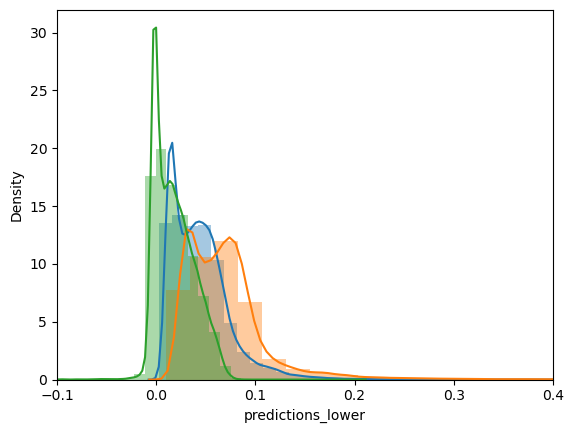

In [86]:
plt.xlim(-.1, .4)

sns.distplot(results_df['predictions_mean']); 
sns.distplot(results_df['predictions_upper']); 
sns.distplot(results_df['predictions_lower']); 

plt.show()

This function calculates the ROC curve for a given set of target (actual) values and predicted probabilities. Then, it computes the difference between the true positive rate (sensitivity) and (1 - false positive rate) for various threshold values. The threshold value with the smallest difference is chosen as the optimal cutoff point. This optimal cutoff point can be used to classify predicted probabilities into classes (e.g., 0 or 1) for a binary classification problem.

In [87]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [88]:
threshold=Find_Optimal_Cutoff(results_df['actual'], results_df['predictions_mean'])[0]

In [89]:
threshold

0.049333442002534866

In [90]:
results_df['impr_mean'] = results_df['predictions_mean'].map(lambda x: 1 if x>threshold else 0)
results_df['clk_mean'] = results_df.apply(lambda row: 1 if (row['actual']==1 and row['impr_mean']==1) else 0, axis=1)

mean_imprs = results_df['impr_mean'].sum()
mean_clicks = results_df['clk_mean'].sum()

In [91]:
mean_ctr=mean_clicks/mean_imprs*100
mean_ctr  ##8% of the users will click imprs

7.952476329206118

In [92]:
results_df['impr_upper'] = results_df['predictions_upper'].map(lambda x: 1 if x>threshold else 0)
results_df['clk_upper'] = results_df.apply(lambda row: 1 if (row['actual']==1 and row['impr_upper']==1) else 0, axis=1)

upper_imprs = results_df['impr_upper'].sum()
upper_clicks = results_df['clk_upper'].sum()

ctr_upper = upper_clicks/upper_imprs*100
ctr_upper  

6.267423851316469

In [93]:
results_df['impr_lower'] = results_df['predictions_lower'].map(lambda x: 1 if x>threshold else 0)
results_df['clk_lower'] = results_df.apply(lambda row: 1 if (row['actual']==1 and row['impr_lower']==1) else 0, axis=1)

lower_imprs = results_df['impr_lower'].sum()
lower_clicks = results_df['clk_lower'].sum()

ctr_lower = lower_clicks/lower_imprs*100

print(mean_ctr, ctr_upper, ctr_lower)

7.952476329206118 6.267423851316469 10.274111675126903


In [94]:
print(mean_imprs, upper_imprs, lower_imprs)
print(mean_clicks, upper_clicks, lower_clicks)

21968 38740 4925
1747 2428 506


In [95]:
22k-1734 clicked

SyntaxError: invalid decimal literal (4252011874.py, line 1)

In [ ]:
click ncrease and ctr decrease-upper-budget high

In [ ]:
click dec annd ctr incr -budget less